### Basic Imports

In [1]:
import nbimporter
from typing import Dict, Tuple, List
import numpy as np
from tqdm import tqdm

### Env Vars

In [2]:
QUBITS_NUM = 4 
N = 16
K = 4
NUM_SHOTS = 1024
NUM_ITERATIONS = 50

w_vector = np.asarray([4,3,2,1])

### Simulator Backend

In [3]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 50
algorithm_globals.random_seed = seed

simulator_backend = Aer.get_backend('qasm_simulator')

### BFGS Optimizer

In [4]:
from scipy.optimize import minimize

### K input states (computational basis)

In [5]:
from utiles import *

In [6]:
input_states = get_first_k_eigenvectors_from_n_computational_basis(K, N)

### Ansatz State

In [7]:
from ansatz_circuit_item2 import get_full_variational_quantum_circuit

In [8]:
init_circuit_params = {
    "thetas": np.random.uniform(low=0, high=2*np.pi, size=8),
    "phis": np.random.uniform(low=0, high=2*np.pi, size=4),
    "D1": 2,
    "D2": 8
}

In [9]:
def prepare_circuit_params(thetas) -> Dict:
     return {
    "thetas": thetas[4:],
    "phis": thetas[:4],
    "D1": 2,
    "D2": 8
     }

In [10]:
def get_ansatz_state(circuit_params, input_state):
    circuit_params_with_input_state = {**circuit_params, "input_state": input_state}
    return get_full_variational_quantum_circuit(**circuit_params_with_input_state)

## Expectation Value

### convert hamiltonian to pauli strings

In [11]:
def transfrom_hamiltonian_into_pauli_strings(hamiltonian) -> List:
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    return pauli_coeffs, pauli_strings

### pauli string reduction to sigma_z's

In [12]:
from qiskit.circuit.library.standard_gates import HGate, SGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [13]:
reducing_to_pauli_z_mapping = {
    'I': 'I',
    'Z': 'Z',
    'X': 'Z',
    'Y': 'Z'
} 

In [14]:
def reduce_pauli_matrixes_into_sigma_z(pauli_string) -> str:
    reduced_pauli_string = ""
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = str(pauli_string[matrix_index])
        reduced_pauli_matrix = reducing_to_pauli_z_mapping[pauli_matrix]
        reduced_pauli_string = reduced_pauli_matrix + reduced_pauli_string
    
    return reduced_pauli_string

In [15]:
def add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string, quantum_circuit):
    quantum_registers = QuantumRegister(QUBITS_NUM, name="qubit")
    additional_circuit_layer = QuantumCircuit(quantum_registers)
    
    for quantum_register_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
        if pauli_string == "Y":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
            additional_circuit_layer.append(SGate(), [quantum_registers[quantum_register_index]])
                
    extended_quantum_circuit = quantum_circuit.compose(additional_circuit_layer)
    return extended_quantum_circuit

### probabilities distribution

In [16]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, simulator_backend) 
    Qobj = assemble(transpiled_quantum_state_circuit)
    result = simulator_backend.run(Qobj).result()
    counts = result.get_counts(quantum_state_circuit)
    
    return get_probability_distribution(counts)

### Expectation value from probabilities

In [17]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def convert_pauli_string_into_str(pauli_string) -> str:
    return str(pauli_string)

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, ansatz_circuit):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    pauli_string_str = convert_pauli_string_into_str(pauli_string)
    extended_ansatz_circuit = add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string_str, ansatz_circuit)
    probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(extended_ansatz_circuit)
    
    reduced_pauli_string = reduce_pauli_matrixes_into_sigma_z(pauli_string)
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

In [18]:
def get_expectation_value(ansatz_circuit, pauli_coeffs, pauli_strings):
    total_expection_value = 0
    
    for pauli_coeff, pauli_string in zip(pauli_coeffs, pauli_strings):
        total_expection_value += pauli_coeff*calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                    pauli_string, ansatz_circuit)
    
    return total_expection_value

## Objective Function

In [19]:
from qiskit import assemble, transpile

def cost_function(thetas, hamiltonian):
    L_w = 0
    circuit_params = prepare_circuit_params(thetas)
    computational_eigenvectors = get_first_k_eigenvectors_from_n_computational_basis(K, N)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(LiH_molecule_4_qubits)
    
    for j in tqdm(range(K)):
        ansatz_state = get_ansatz_state(circuit_params, computational_eigenvectors[j])
        approximated_energy = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
        insert_approximated_energy_to_list_of_all_approximated_energies(
            approximated_energies_dict["approximated_eneriges_"+str(j)], approximated_energy)
        L_w += w_vector[j]*approximated_energy
        
    return L_w

### Optimization

In [20]:
def get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian):
    initial_thetas = np.random.uniform(low=0, high=360, size=12)
    optimizer_result = minimize(
                            cost_function,
                            x0=initial_thetas,
                            args=(hamiltonian),
                            method="BFGS",
                            options={"maxiter":NUM_ITERATIONS})
    optimal_thetas = prepare_circuit_params(optimizer_result.x)
    
    return optimal_thetas

In [21]:
def get_approximated_k_eigenvalues_of_hamiltonian(hamiltonian):
    approximated_k_eigenvalues = []
    optimal_thetas = get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian)
    computational_eigenvectors = get_first_k_eigenvectors_from_n_computational_basis(K, N)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    for eigenvalue_index, eigenvector in enumerate(computational_eigenvectors):
        optimal_ansatz_state = get_ansatz_state(optimal_thetas, eigenvector)
        approximated_eigenvalue = get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings)
        approximated_k_eigenvalues.append(approximated_eigenvalue)

    return approximated_k_eigenvalues

## Comparsion

In [22]:
from numpy import linalg as LA
from statistics import mean

def get_mean_approximation_error(exact_k_eigenvalues, approximated_k_eigenvalues):
    approximated_errors = []
    for exact_eigenvalue, approximated_eigenvalue in zip(exact_k_eigenvalues, approximated_k_eigenvalues):
        approximated_errors.append(abs(abs(exact_eigenvalue)-abs(approximated_eigenvalue))/abs(exact_eigenvalue))
        
    return mean(approximated_errors)

In [23]:
def get_exact_k_eigenvalues_of_hamiltonian(hamiltonian, k):
    eigenvalues = LA.eig(hamiltonian.to_matrix())[0]
    
    return sorted(eigenvalues)[:k]

In [24]:
def compare_exact_and_approximated_eigenvectors(hamiltonian, approximated_k_eigenvalues):
    exact_k_eigenvalues = get_exact_k_eigenvalues_of_hamiltonian(hamiltonian, K)
    print("Exact K Eigenvalues:")
    print(exact_k_eigenvalues)
    
    print("\nApproximated K Eigenvalues:")
    print(approximated_k_eigenvalues)

    print("\nMean Approximation error:")
    print(get_mean_approximation_error(exact_k_eigenvalues, approximated_k_eigenvalues))

## Visualization

In [25]:
approximated_energies_dict = { "approximated_eneriges_0": [],
"approximated_eneriges_1":[],
"approximated_eneriges_2": [],
"approximated_eneriges_3": []}

In [26]:
def initialize_approximated_energies_dict():
    return { "approximated_eneriges_0": [],
        "approximated_eneriges_1":[],
        "approximated_eneriges_2": [],
        "approximated_eneriges_3": []}

In [27]:
def insert_approximated_energy_to_list_of_all_approximated_energies(approximated_energies_list, energy):
    approximated_energies_list.append(energy)

In [28]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_convergence_of_optimization_process(approximated_energies, hamiltonian, margin=0.02):
    plt.title("convergence of optimization process to the exact eigenvalue")
    plt.margins(0,margin)
    base_colors_list = list(mcolors.BASE_COLORS.keys())
    
    exact_k_eigenvalues = get_exact_k_eigenvalues_of_hamiltonian(hamiltonian, K)
    print(exact_k_eigenvalues)
    for energy_level, eigenvalue in enumerate(exact_k_eigenvalues):
        energy_level_name = "E_{0}".format(str(energy_level))
        
        plt.axhline(y = eigenvalue, 
                    color = base_colors_list[energy_level], 
                    linestyle = 'dotted', label=energy_level_name)
        plt.plot(approximated_energies["approximated_eneriges_{0}".format(str(energy_level))],
                 color = base_colors_list[energy_level], 
                 label="Weighted_SSVQE({0})".format(energy_level_name))
    
#     plt.plot(approximated_energies["approximated_eneriges_0"])
#     plt.plot(approximated_energies["approximated_eneriges_1"])
#     plt.plot(approximated_energies["approximated_eneriges_2"])
#     plt.plot(approximated_energies["approximated_eneriges_3"])
    
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
def plot_fidelity():
    plt.plot(LiH_approximated_energies)
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")

## LiH Molecule 4 qubits

In [29]:
from qiskit.opflow import X, Z, Y, I, H, S

In [30]:
LiH_molecule_4_qubits = -7.49894690201071*(I^I^I^I) + \
-0.0029329964409502266*(X^X^Y^Y) + \
0.0029329964409502266*(X^Y^Y^X) + \
0.01291078027311749*(X^Z^X^I) + \
-0.0013743761078958677*(X^Z^X^Z) + \
0.011536413200774975*(X^I^X^I) + \
0.0029329964409502266*(Y^X^X^Y) + \
-0.0029329964409502266*(Y^Y^X^X) + \
0.01291078027311749*(Y^Z^Y^I) + \
-0.0013743761078958677*(Y^Z^Y^Z) + \
0.011536413200774975*(Y^I^Y^I) + \
0.16199475388004184*(Z^I^I^I) + \
0.011536413200774975*(Z^X^Z^X) + \
0.011536413200774975*(Z^Y^Z^Y) + \
0.12444770133137588*(Z^Z^I^I) + \
0.054130445793298836*(Z^I^Z^I) + \
0.05706344223424907*(Z^I^I^Z) + \
0.012910780273117487*(I^X^Z^X) + \
-0.0013743761078958677*(I^X^I^X) + \
0.012910780273117487*(I^Y^Z^Y) + \
-0.0013743761078958677*(I^Y^I^Y) + \
0.16199475388004186*(I^Z^I^I) + \
0.05706344223424907*(I^Z^Z^I) + \
0.054130445793298836*(I^Z^I^Z) + \
-0.013243698330265966*(I^I^Z^I) + \
0.08479609543670981*(I^I^Z^Z) + \
-0.013243698330265952*(I^I^I^Z)

In [31]:
%%time
LiH_approximated_k_eigenvalues = get_approximated_k_eigenvalues_of_hamiltonian(LiH_molecule_4_qubits)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:36<00:00,  9.14s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:33<00:00,  8.30s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:29<00:00,  7.40s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:28<00:00,  7.05s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.89s/it]


CPU times: total: 2h 25min 22s
Wall time: 3h 3s


In [32]:
compare_exact_and_approximated_eigenvectors(LiH_molecule_4_qubits, LiH_approximated_k_eigenvalues)

Exact K Eigenvalues:
[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j)]

Approximated K Eigenvalues:
[-7.10378854381129, -7.68896344989727, -7.497286052589076, -7.714201879655632]

Mean Approximation error:
0.03635983021442056


In [33]:
print(approximated_energies_dict)
approximated_energies_dict = initialize_approximated_energies_dict()

{'approximated_eneriges_0': [-7.091528095582735, -7.094732399514073, -7.102631572700521, -7.092430624438756, -7.0821886910190175, -7.099600459489767, -7.104430329637183, -7.093569926448577, -7.102980624980311, -7.0965167898793755, -7.092218293251719, -7.105456831456595, -7.094151679389267, -7.315580421320068, -7.306981719743723, -7.323515508113914, -7.302273618578137, -7.298366231702145, -7.290922154529752, -7.30328315778472, -7.327833834988739, -7.311189783252137, -7.309811172926783, -7.310259995708834, -7.2991377151900565, -7.2923383641662625, -7.237092688327237, -7.254286517160121, -7.244438368536549, -7.258647752776217, -7.244408976337695, -7.254153875149671, -7.232820436665985, -7.239643538252206, -7.248159378994081, -7.248638210054703, -7.251518981066425, -7.236571224148207, -7.25282142762817, -7.16551468701862, -7.1594715206428345, -7.159677593477942, -7.167604685404221, -7.17192643656838, -7.1612112655238525, -7.1535194184018325, -7.175853423109947, -7.153959758230336, -7.15952

[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j)]


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


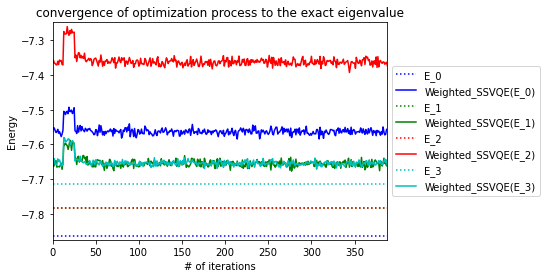

In [34]:
LiH_approximated_energies = {'approximated_eneriges_0': [-7.562071486292104, -7.551346757429608, -7.552944523914135, -7.560116772775394, -7.565448199837231, -7.562546777411176, -7.556370586953186, -7.5674961396597515, -7.562868323640123, -7.569727297671011, -7.577241001152592, -7.569901653592553, -7.560170928569707, -7.50450294015484, -7.507421280130349, -7.513641444931524, -7.505252370983593, -7.504378338149738, -7.511089721083689, -7.492616949145766, -7.504733592874844, -7.505057286909975, -7.500944996847547, -7.510777395650015, -7.50684214460726, -7.494074441023492, -7.560548573373164, -7.562214184024206, -7.568477882703838, -7.5455461632531655, -7.564340538776625, -7.553988541052734, -7.5451955641745085, -7.5609456305954925, -7.5483501889539975, -7.556677716954072, -7.56005590213002, -7.5631439275507315, -7.553392111383577, -7.556743753345377, -7.561551788828242, -7.555342548733728, -7.556766445089764, -7.553542895341899, -7.559683391361186, -7.560925469458819, -7.563572357485119, -7.567151568002535, -7.571946591188674, -7.570142191678787, -7.557106639758928, -7.558439292968819, -7.574579104067784, -7.562883709761341, -7.543713858491556, -7.564720803456668, -7.5457497014403065, -7.558969672912834, -7.572319575797064, -7.56292452904019, -7.573479760327174, -7.562199030564257, -7.568681686528937, -7.563004496841959, -7.560909055570279, -7.563440128011368, -7.559393749815729, -7.555472180892113, -7.562844249951609, -7.558531024188177, -7.575698822248928, -7.55404084909291, -7.567979735908607, -7.557018847801117, -7.560978919569245, -7.561794829078547, -7.562143635631656, -7.566271922325941, -7.560839611270146, -7.5568033902098195, -7.58142513791027, -7.573881846816633, -7.558732728073843, -7.56231060585952, -7.551624934331701, -7.551909164866761, -7.5638131868631815, -7.549845397747916, -7.5589181330700805, -7.540495085034901, -7.577617386377836, -7.562660697312212, -7.5559425308224695, -7.561386635696937, -7.577264904915713, -7.553963097036648, -7.573178097168689, -7.580582024019519, -7.5702738283835815, -7.556843980390578, -7.559149777706205, -7.569885360295614, -7.567209735965058, -7.555616248808023, -7.568195665853206, -7.568236031253794, -7.569588764497501, -7.5469170982088745, -7.551910171848012, -7.56070080426784, -7.55777115024099, -7.559179078756845, -7.571503944007687, -7.563577336071192, -7.568322764040547, -7.570259682411341, -7.5752124577109825, -7.574351422210891, -7.568048101368627, -7.5574802857572765, -7.5698666855121735, -7.574140547848547, -7.562281537007218, -7.560887200033612, -7.561833170760727, -7.566703915939199, -7.557248337704557, -7.552393839555408, -7.564795356944313, -7.563885543697337, -7.559295993912143, -7.551819460291054, -7.558610716537125, -7.572150334020591, -7.564829143448873, -7.5649749821297005, -7.559880775892233, -7.562095014235116, -7.555258749423826, -7.563330197776976, -7.576172555094606, -7.56109702344153, -7.560220437853168, -7.563316771592021, -7.55927764982648, -7.559489229938778, -7.560311914696335, -7.5758565696485105, -7.575167851245861, -7.559661332074081, -7.570187549559718, -7.565836319171639, -7.561504371857765, -7.57023042999233, -7.557965382900609, -7.5588943241487385, -7.565503057849797, -7.566276315012363, -7.556233953236954, -7.555144578373757, -7.573777660175128, -7.559991356466428, -7.542063221770774, -7.559407920550896, -7.568143821006155, -7.563686528171099, -7.5642605095860445, -7.5618362170315825, -7.571431894796191, -7.553895503314807, -7.5582535646354065, -7.567586909130106, -7.565961202348206, -7.568978997128765, -7.559340951338928, -7.56445806146827, -7.5556876792359695, -7.56460053303355, -7.570850901726988, -7.568585489747921, -7.557607035779572, -7.564746300706346, -7.561021813150516, -7.562876730931318, -7.571504302167662, -7.561367947755987, -7.566122191231275, -7.560375807672051, -7.561596670973815, -7.557932614828941, -7.560059245807887, -7.569372561667943, -7.577526582464007, -7.565419191759633, -7.560723711434731, -7.560687793830521, -7.567853605434033, -7.5695315149905165, -7.559057395081173, -7.576396592141188, -7.569482907819277, -7.566176238781431, -7.559480733078293, -7.555440467881515, -7.5722562004117355, -7.563561051500816, -7.569102134783019, -7.5624251768939255, -7.553238644209887, -7.566688525378806, -7.57427446525249, -7.5630089364129, -7.559170646039951, -7.573016576285714, -7.584234644863586, -7.563774665710167, -7.559999708140727, -7.558618140639516, -7.55225503083047, -7.557642799541379, -7.563901866709506, -7.553289758355393, -7.558633780019458, -7.572573129411478, -7.557194844186757, -7.556664728469042, -7.559564789456388, -7.565594323797267, -7.555190264866648, -7.561624263586976, -7.569789625285521, -7.5690157809803456, -7.544118474969882, -7.561047611370386, -7.554555222654382, -7.546317221250312, -7.567349270266024, -7.5673888180098325, -7.561428441164426, -7.560936846098908, -7.583650803960547, -7.572308414798167, -7.557746434820991, -7.563764459606351, -7.5587571353624, -7.563416427888439, -7.569696456404504, -7.562540355868497, -7.560495854027838, -7.567457286444577, -7.570867740017869, -7.567086356575003, -7.560381244145666, -7.547049169199666, -7.555784321622338, -7.569474376081687, -7.5722757014839654, -7.560066374314964, -7.554831247356704, -7.549778933470774, -7.550601706977019, -7.570006340302589, -7.564876409869264, -7.564559009400159, -7.560123971954665, -7.5565573892896944, -7.5491087521206195, -7.570018687683115, -7.553176898896319, -7.5638762714361905, -7.558619243737311, -7.555619087766442, -7.564029863039117, -7.555163295228039, -7.56290446645362, -7.575012659147997, -7.552840275809348, -7.5799696493221855, -7.567475401942004, -7.56305130559502, -7.563508335327721, -7.555894563238186, -7.572075891781376, -7.555604946309137, -7.558284106172176, -7.567270751416418, -7.552151995055932, -7.573093018147093, -7.565849448615926, -7.560728523332386, -7.561475572421954, -7.557857962584839, -7.57102858041606, -7.5601827041613445, -7.5473846644268905, -7.567554019242569, -7.566923472324098, -7.571172604068238, -7.573534646914643, -7.568365397345586, -7.573096907598021, -7.568072358316656, -7.5624371348290484, -7.569334313303235, -7.569107128693299, -7.569438063580029, -7.557081199304223, -7.556793444721364, -7.565564138171619, -7.584047083603657, -7.550468510480313, -7.5721701200656755, -7.561405357628065, -7.568843499808381, -7.582132396455182, -7.56188172212797, -7.565780797594704, -7.5581809752026645, -7.563924689693823, -7.568310006966299, -7.570973966169818, -7.566526969313047, -7.556837856869171, -7.556959357100385, -7.55802539600483, -7.560157547145864, -7.558819606357595, -7.5716432114033685, -7.574679379170924, -7.558314028696738, -7.5592360010565995, -7.552304228834449, -7.567720644203105, -7.553819160843, -7.564363448769347, -7.5667092400451255, -7.558673226311031, -7.557102272988306, -7.56406445986514, -7.550601245662824, -7.5642687847953, -7.562428841944573, -7.554217816157429, -7.567761628415078, -7.559682214760878, -7.571207288584289, -7.550142299269893, -7.570586131073872, -7.5605912454613655, -7.556847794745476, -7.559811269546062, -7.570036341292319, -7.564677334894062, -7.563188252164309, -7.563738648634944, -7.562081214609168, -7.565029085996614, -7.552285855207653, -7.5587401551887785, -7.567044590000477, -7.554827834724664, -7.564142970628503, -7.570785867741189, -7.5568222014998785, -7.565658174898904, -7.56968748071879, -7.554067354326688, -7.566300026647628, -7.55845704485936, -7.551501158686343, -7.561167024505615, -7.573625008309388, -7.559870114940783, -7.565501456554783, -7.561293415371925, -7.574687001507515, -7.55926251913646, -7.563852554125366, -7.560994576121271, -7.566721437077942, -7.573291148108524, -7.562883029407168, -7.570158159077053, -7.549374795901499, -7.5640639695420075, -7.572251998484766, -7.570972389043582, -7.557080874727251, -7.5547683042560685], 'approximated_eneriges_1': [-7.640004876805808, -7.663640722664111, -7.658611929963564, -7.64932547704183, -7.646797803653223, -7.665442251078073, -7.663642689359795, -7.663556103716576, -7.664762017962395, -7.659539943254729, -7.653825233560599, -7.671736337391423, -7.655284105369079, -7.597651501673428, -7.601322561951349, -7.597295701081217, -7.5995434567321745, -7.603809864776037, -7.614372704985102, -7.603637104328402, -7.587494654856017, -7.595271793938281, -7.616879795695566, -7.589553721419916, -7.596416341830358, -7.596034796833454, -7.636209438889688, -7.640877649341832, -7.657679139320576, -7.6363317069501715, -7.634009690454076, -7.650685810199302, -7.642970968474241, -7.647171253048493, -7.649113730245329, -7.632589528503865, -7.631625548600127, -7.640657607231181, -7.637011643554965, -7.6519853787423715, -7.6346252169762785, -7.659438164187605, -7.649134794688484, -7.656067137177791, -7.656308879678295, -7.656600376216503, -7.664776501884009, -7.654613607723093, -7.664969430903149, -7.648273559419987, -7.664870709406619, -7.6469497023504225, -7.643659500147412, -7.645751102067645, -7.646286196764285, -7.6459080652210885, -7.651782113361833, -7.658184809230566, -7.646392105677173, -7.659855511304261, -7.674622701536653, -7.653690153821832, -7.657108979247705, -7.669192622856933, -7.659338187830021, -7.659255866767289, -7.642787974230109, -7.645383883879427, -7.662495541010129, -7.655440842815017, -7.669557208297275, -7.6756909723728795, -7.649491309169715, -7.652262225804263, -7.662422713416752, -7.659914401465116, -7.6639905955020815, -7.6566673637561715, -7.6586633675018625, -7.668702497209907, -7.656154354812613, -7.659014207552145, -7.665265620831511, -7.652713926513206, -7.658480326185389, -7.64981261192683, -7.654614416145373, -7.66396866337189, -7.661425047413697, -7.65942993358875, -7.658563520972784, -7.6514926583190634, -7.644135199378931, -7.642104164460429, -7.669130202549792, -7.643096426186087, -7.654953306643982, -7.662778253610977, -7.662008704804949, -7.662297656266985, -7.664652442531045, -7.662341568683591, -7.650731033972629, -7.65865575908331, -7.6594704205503, -7.652988061222755, -7.661235266653203, -7.653987188331512, -7.651868104406244, -7.651944984193438, -7.657564091355315, -7.640071623656383, -7.652522066174303, -7.662010083630387, -7.647888345260418, -7.650936792580378, -7.655897253299694, -7.653322392254577, -7.644805038244322, -7.652796357049603, -7.659324658913715, -7.650261760707197, -7.662121270587388, -7.655967589917249, -7.6517776917299845, -7.661450519934126, -7.641166197403465, -7.655404138361534, -7.648879831917093, -7.657596913720103, -7.6590897115736984, -7.64991776437358, -7.656498968379245, -7.662734745207417, -7.6513120368663055, -7.644002948397324, -7.657408606711758, -7.660792912880495, -7.660712711942249, -7.649928308881624, -7.649335433945487, -7.653650140193882, -7.652255933020255, -7.639367216167971, -7.662778846906539, -7.652260591782108, -7.650598648861375, -7.662590372653764, -7.650342710622928, -7.6501448723513725, -7.658949388846702, -7.651395906431559, -7.656810220714922, -7.6321390678820205, -7.650008411682383, -7.665943429318839, -7.659303769636394, -7.66175343609437, -7.664889400703618, -7.660941428234831, -7.655777486687101, -7.639890218869916, -7.6404586733828, -7.646546669058496, -7.641522175777968, -7.653600965386103, -7.658168313069703, -7.663408087736834, -7.64237595177724, -7.647074326535779, -7.662532146997315, -7.641935778444564, -7.664735283161793, -7.649548709483991, -7.652085538245844, -7.666668508392412, -7.639771290700313, -7.649496158587092, -7.6568362596053605, -7.655744241997743, -7.664685030863114, -7.663826007050182, -7.649790587112996, -7.64443378177775, -7.658059841719335, -7.653514123802562, -7.653854477512821, -7.646481685942946, -7.668778512368588, -7.66931149740886, -7.647086355555541, -7.641207585483791, -7.662796697913889, -7.654944710173036, -7.639670433309078, -7.662647849868859, -7.659169336973351, -7.649045024363313, -7.649902950465767, -7.660845152542733, -7.64997346217619, -7.659656505795857, -7.646712215566484, -7.653523082543233, -7.649493675081297, -7.655471393693474, -7.674354557783189, -7.649868727439205, -7.657708573676187, -7.648498237270756, -7.6535668913852035, -7.654604999387128, -7.657184118242257, -7.661015568187299, -7.647850392858409, -7.658511169027303, -7.658972301781452, -7.6627155202222905, -7.659343425662869, -7.6653726330212875, -7.644723460329305, -7.668724873820755, -7.659938937532452, -7.664237945432445, -7.652549577013326, -7.654151510415249, -7.669238815055444, -7.666681401675911, -7.669218431486016, -7.647179612366595, -7.655195040863664, -7.663883794389363, -7.656220095677754, -7.652714111757331, -7.660091731494186, -7.653382972001038, -7.649685032899117, -7.643434026734703, -7.653779360455354, -7.649040098024922, -7.650736086171822, -7.662868198158262, -7.6501933250935155, -7.64973877850863, -7.657948064113084, -7.662622266990542, -7.663076116756231, -7.650314400813861, -7.6636252982682045, -7.6493285100228166, -7.655115749146944, -7.644262568636023, -7.654237639095005, -7.6736574011945455, -7.6493474525286445, -7.647472666863004, -7.659184047322648, -7.65912277649649, -7.6654110550839665, -7.661775451342709, -7.649639297095291, -7.653073388579447, -7.655681166370746, -7.647732810883867, -7.6619795234069725, -7.639049506367911, -7.656046843463907, -7.659363290452618, -7.6565259542680195, -7.653607621717966, -7.653468958961931, -7.6646939127860305, -7.664208775193248, -7.6580143217798575, -7.640833891558509, -7.6742343740424745, -7.6368088827610965, -7.676849993512226, -7.660514920077705, -7.651583484887268, -7.668268592423068, -7.6646010667684195, -7.642075015284122, -7.662675943256403, -7.664589673885046, -7.654168128102824, -7.652899497355082, -7.656562292144806, -7.65441159181004, -7.653903217180547, -7.653699566381234, -7.65916383616381, -7.652062498055793, -7.659770782365602, -7.649973183440041, -7.658416249308681, -7.648280662215833, -7.657440584268751, -7.653280984673626, -7.654650326352021, -7.651503976021746, -7.650725270622099, -7.650953823305091, -7.663453719577422, -7.663136563134576, -7.648552058672743, -7.645717317561624, -7.661677391075099, -7.650639645207763, -7.653162448343972, -7.647940290358222, -7.65349195437921, -7.655227609743165, -7.660800320152206, -7.655876286253898, -7.653362417457495, -7.662900578450083, -7.665759889583327, -7.64850603317317, -7.64639804610784, -7.657554964336688, -7.653934318847597, -7.656989653718636, -7.654003033193125, -7.663278274501233, -7.666423380077609, -7.655046975756818, -7.66894116678348, -7.661409124458723, -7.654453806674957, -7.6498362917783425, -7.659479111374668, -7.65850880813774, -7.649723814710095, -7.668599193491497, -7.653559251181374, -7.651880099847571, -7.648275147789655, -7.652882577216799, -7.644777263225337, -7.665841694995836, -7.657295888566798, -7.650380545448417, -7.639585679978297, -7.665489676763162, -7.6548503410482525, -7.6436946240394175, -7.663573440940202, -7.649710258532595, -7.655170355908884, -7.657163682467192, -7.664515491695974, -7.654927719140413, -7.652749483894446, -7.663378842271306, -7.647988315215243, -7.662107961183042, -7.66474215776545, -7.637231085764769, -7.665794116547952, -7.659041651972093, -7.648965313349237, -7.67295614592449, -7.665980286725987, -7.652996229373012, -7.665622980515267, -7.659422815244974, -7.644928616011809, -7.658062566347961, -7.666474881683342, -7.642640171231159, -7.664938294267261, -7.662099851005686, -7.64814476099854, -7.644567976847967, -7.648680150743558, -7.655541946192065, -7.653112692719887, -7.6538334178079985, -7.675629929335296, -7.647642939973969, -7.650061824260243, -7.66209311769753, -7.653972963672962, -7.639499794912201, -7.654796842420962, -7.653923396462375, -7.6617034515694415, -7.655354344789989], 'approximated_eneriges_2': [-7.364883295491945, -7.357096546692957, -7.364955640080209, -7.366649835041585, -7.370178562738035, -7.370498295639986, -7.359850343021811, -7.369578873911706, -7.356601813997492, -7.358935651502489, -7.357796998557633, -7.369132170244881, -7.370702735100627, -7.274325050775206, -7.280474963079358, -7.281708787780506, -7.280556555262666, -7.259920023445053, -7.2785681459669185, -7.285094941009067, -7.271930987000509, -7.28050081577424, -7.268045134634672, -7.277905509462009, -7.27674183916798, -7.276019138655873, -7.349741384646146, -7.342049394958048, -7.360711308891955, -7.346157367111212, -7.335181510651091, -7.336460259713555, -7.3503315982180135, -7.343012489174863, -7.350680303032871, -7.346283858351786, -7.352005549652531, -7.336713141766783, -7.356632635936495, -7.361404363466478, -7.358421968675841, -7.354922720317311, -7.351437910086754, -7.357982322018829, -7.352521671214343, -7.355041799412635, -7.372545589228418, -7.365964181946214, -7.354378458902148, -7.351744159257381, -7.350925066165386, -7.357593585644726, -7.365417233199112, -7.373991478179518, -7.3577941933998945, -7.362401413580458, -7.341856930596256, -7.357240928256174, -7.374309349711194, -7.360958542921878, -7.371926808040107, -7.35921402377884, -7.35916547028286, -7.3550199505559, -7.366133377644873, -7.360252875959583, -7.36491881346327, -7.365101181103266, -7.359053414111484, -7.349971883701548, -7.355873314161922, -7.364197131055456, -7.349489968783213, -7.379722885394727, -7.365049225884977, -7.36513158165031, -7.3576457118603225, -7.3478126411856355, -7.359695751641573, -7.363930333905528, -7.349666773192882, -7.356555741062991, -7.355265448516789, -7.349977444810509, -7.374642461822476, -7.360300171932341, -7.359505475536327, -7.368607076371499, -7.360185531224295, -7.349101735894524, -7.357138676351334, -7.3663064895982755, -7.364408680050643, -7.3580092192110484, -7.377681633783077, -7.367018245907511, -7.367140560080904, -7.357926512249714, -7.356207859208334, -7.358837568245287, -7.374082391099257, -7.368961270707655, -7.351394731165236, -7.366897363688458, -7.366428644422809, -7.369338966260864, -7.36895670581141, -7.352156787314955, -7.356311636601875, -7.368418487568985, -7.373618062975586, -7.365514562347909, -7.356458967476127, -7.350140557450977, -7.37430744555474, -7.365384180212878, -7.352452685490337, -7.365023570169725, -7.361808388584072, -7.366480133321798, -7.370469022282186, -7.352470346207248, -7.346992599713914, -7.3754666982799115, -7.367119981302624, -7.375893544945889, -7.3740184962020905, -7.360680688128673, -7.365533613211296, -7.3730267896333705, -7.378733399096636, -7.360938272380674, -7.3500785793055465, -7.356501828157371, -7.366701043649846, -7.360983720125592, -7.358977885377021, -7.359012030942887, -7.352071018778803, -7.358936876603126, -7.361806178157059, -7.343776779523118, -7.358320360826148, -7.356750472294554, -7.376891375456355, -7.361193797092221, -7.359021412991975, -7.365210523648424, -7.371075560503611, -7.366035104467214, -7.362885977563602, -7.378921723610643, -7.372516628456746, -7.365388770096758, -7.371996227457732, -7.360685568580893, -7.355651305069363, -7.374063334270516, -7.36866991119594, -7.366995215528181, -7.345944236817251, -7.376284921962682, -7.36334282363693, -7.355108514618833, -7.372041071067884, -7.365471765439953, -7.360843606108303, -7.353623255424593, -7.362459109079309, -7.374708343638556, -7.375105765383493, -7.364208223403619, -7.345214366910676, -7.364592321183875, -7.375684202992255, -7.367155527390262, -7.369246432134271, -7.360956615963479, -7.3619580616206255, -7.360459486794811, -7.371675296672397, -7.356317658441366, -7.374757871217501, -7.354379174387812, -7.366613426064128, -7.38178307075689, -7.366224634504145, -7.3597296489938495, -7.358974064648617, -7.3707272321459705, -7.373501209369182, -7.369675184795953, -7.3600172244870885, -7.3584439569990145, -7.366941946200081, -7.360982002370062, -7.359365301566428, -7.356006337639239, -7.34400178778242, -7.373952991273524, -7.358046504039474, -7.361604134578873, -7.349473609764614, -7.349403104466897, -7.3767576363243075, -7.35830652373711, -7.36174226205589, -7.373306073689175, -7.345617022309214, -7.366876143439954, -7.366985309233789, -7.357764798093134, -7.3591288311835985, -7.370257264352036, -7.358829371334706, -7.362238737252088, -7.344988673601462, -7.372449096327162, -7.371956426469645, -7.367637030712678, -7.354838786384415, -7.362342881621784, -7.353367159874581, -7.371558090338945, -7.372199508284778, -7.35559097590597, -7.352243472769708, -7.372060080386132, -7.358686593539402, -7.3706724142617706, -7.35528444874002, -7.362738558888143, -7.355687112281264, -7.361605788363014, -7.36476037660511, -7.357733503929607, -7.363214644109992, -7.3548389973015205, -7.3624925989230015, -7.359600708446874, -7.362931574957735, -7.358987677040328, -7.35107500006582, -7.356836143359705, -7.3546345900017345, -7.365944078095171, -7.364932472499365, -7.354398522173845, -7.357521665275058, -7.3768288423220465, -7.363289402239592, -7.343251478135545, -7.360503842060538, -7.3657683868095525, -7.348601589128535, -7.379870520124686, -7.349147391443481, -7.35970074286777, -7.371717356100115, -7.3588632737725, -7.368721429055141, -7.372265570186838, -7.353054140753173, -7.3577394252567245, -7.372738937492774, -7.349981341418335, -7.362565214437743, -7.364257487214802, -7.3610516071290935, -7.369268591142921, -7.355984717690602, -7.375194815193234, -7.36660973034524, -7.360138439964464, -7.370244045912211, -7.369368625502614, -7.365497694840824, -7.3724084362573, -7.362925924196621, -7.347527321193012, -7.354291928077748, -7.35483990109757, -7.376337424603696, -7.371389952666957, -7.366761093082787, -7.372038595248641, -7.3680292245858094, -7.372723879313842, -7.363111018625149, -7.352063570845146, -7.345940916439905, -7.370254067980764, -7.360839880193324, -7.356968204531796, -7.375528971249572, -7.371525868883696, -7.366754845337612, -7.370661731668315, -7.363084430101188, -7.362918987834069, -7.345723412236612, -7.366278292894045, -7.367094020811365, -7.370071839080922, -7.355364845487074, -7.368284885887138, -7.360124877456739, -7.354994688626578, -7.3649098543665605, -7.368282072577719, -7.345924708354052, -7.380842586667604, -7.36035334136359, -7.367649143212794, -7.3468891173007576, -7.354487074423081, -7.372476545988491, -7.370300266609272, -7.358185550263161, -7.358180712409783, -7.360590387167875, -7.357973406423506, -7.357492691696578, -7.36617128229452, -7.362170473006855, -7.3702491149201705, -7.347250830941381, -7.359065286033125, -7.360842711648379, -7.378426535571467, -7.354302172414079, -7.368199657726918, -7.369243498740597, -7.3626572837470805, -7.363192801642301, -7.365984259252732, -7.359957831263764, -7.354055670115411, -7.368901208708802, -7.365499387028483, -7.362057052695473, -7.36076061134795, -7.3578582420012895, -7.371070206494654, -7.392501032402848, -7.376719315384669, -7.36192020558924, -7.360572803680353, -7.364382834805135, -7.365781587067929, -7.364656255448828, -7.380197508773036, -7.348680263515486, -7.358557567638165, -7.365514533951133, -7.366222672189137, -7.356699052111834, -7.3634482860254895, -7.373209883567622, -7.355686002369842, -7.355419510511128, -7.349642719346203, -7.369344424565576, -7.345344548791268, -7.349659686199744, -7.348036040021483, -7.357953762034859, -7.355311612895259, -7.3714317232624795, -7.368810683670823, -7.359104369519746, -7.376622354423639, -7.360661288659202, -7.358520301623136, -7.36905661413032, -7.347537418729239, -7.377781546220456, -7.346710534929065, -7.37635041750454, -7.359992541999637, -7.357895645444458, -7.3637267758526805, -7.3659965989369205, -7.361875087672914, -7.362226066535422, -7.3687739171144875, -7.365454390248908, -7.3628051566367585, -7.3732335815428875], 'approximated_eneriges_3': [-7.665565108452975, -7.644901323573956, -7.640844028472312, -7.657254406209585, -7.658112461896535, -7.6568392828816485, -7.641390104849172, -7.6495594099925075, -7.644551215257205, -7.651378183593319, -7.662443144196291, -7.660808970446244, -7.6543644719951525, -7.579787725328885, -7.581575393716733, -7.593278932861819, -7.590112185247835, -7.58835070414362, -7.583838150366188, -7.584132884149633, -7.592723154742481, -7.600588992249034, -7.592989439982904, -7.589170555867332, -7.593330942586447, -7.598103983431033, -7.647418576300137, -7.642912816923083, -7.643896476593707, -7.641910200029536, -7.647168635191645, -7.647767599627591, -7.633891335931415, -7.6451174744419985, -7.648916011463749, -7.651596453059482, -7.652658602598597, -7.64925018366965, -7.652250819847233, -7.657391563539323, -7.65628022876998, -7.654372267148436, -7.6523680940147445, -7.646153944349784, -7.652891448904207, -7.662720272184743, -7.655418609074423, -7.645235055261529, -7.652248466967251, -7.658587503126946, -7.6441011073686935, -7.6472521312812125, -7.65578417759617, -7.65404932384636, -7.659074178854031, -7.652171967879082, -7.647353474046499, -7.653043857292235, -7.663262076576875, -7.658974031516964, -7.659773413941099, -7.659877261166179, -7.650674734519757, -7.657871577038285, -7.65218856996915, -7.661315019158188, -7.6608784060476145, -7.65903856685483, -7.650325258864766, -7.657149241987326, -7.6628369554438285, -7.662751902402708, -7.645830978532802, -7.659705924776128, -7.652202748407217, -7.648512995889111, -7.656062033485538, -7.658772090432675, -7.650168027354398, -7.652133754969269, -7.655634089834825, -7.6431287117715, -7.655701260178208, -7.6587933437074955, -7.646927138838895, -7.653111758973935, -7.64804338104222, -7.653306776277115, -7.650322200330327, -7.658879834821313, -7.654179963065271, -7.656924300725593, -7.65694024588232, -7.656643964370596, -7.653438994580543, -7.649654583407108, -7.6588747071651495, -7.661711976348323, -7.657942056516167, -7.6594176679534325, -7.6528382751568715, -7.648300771051253, -7.661655766275675, -7.652026357240133, -7.65484995311952, -7.663627660016132, -7.651696269976716, -7.651471203760689, -7.652688549766444, -7.650547795465464, -7.651428913845321, -7.654107023102959, -7.657571795914727, -7.652314051456776, -7.666254772709962, -7.662168392311318, -7.659842820238239, -7.664331049356466, -7.638036033198543, -7.661709974700356, -7.662459543469471, -7.647034607710653, -7.659347907334266, -7.654787706962608, -7.654339593062118, -7.6568974256567675, -7.646013658991441, -7.653099765259573, -7.650685693922264, -7.645383824147363, -7.655803522857804, -7.655403941428183, -7.650291960134789, -7.658776048487579, -7.652609631803865, -7.659541764373261, -7.654301165389112, -7.6505070594856015, -7.659838781640751, -7.653483388689125, -7.646318468699023, -7.653631379836062, -7.656315380826935, -7.660255323117884, -7.654990375238988, -7.641225742649195, -7.66405826389239, -7.654271860620266, -7.646634129130455, -7.650510510955897, -7.658728753991629, -7.645926973626786, -7.654701123754429, -7.638272916158379, -7.656332674300085, -7.653863882992666, -7.648837320500792, -7.640387250122717, -7.649244359784344, -7.650268513395258, -7.652866967189823, -7.6523557891630265, -7.643888963175816, -7.649627701754415, -7.652111005299847, -7.655242582599543, -7.651078841908696, -7.656342772524407, -7.66086562676355, -7.654187509979265, -7.652723758952326, -7.655343044873772, -7.655318868132087, -7.6525909880558265, -7.652632307738305, -7.650951036901952, -7.669286096861051, -7.652350772420757, -7.660446851056735, -7.659401097867884, -7.658145954855402, -7.65598015342052, -7.6585818022757906, -7.658411845818654, -7.662098249242379, -7.645861239029599, -7.653301645718722, -7.648596669553275, -7.655410214618722, -7.653651454737528, -7.653108457752997, -7.668396591214985, -7.651742330838472, -7.643272221341881, -7.6480076113614475, -7.646105722075325, -7.657937872190927, -7.653099062217942, -7.666011461331249, -7.645951841928547, -7.661057330564267, -7.653346502650349, -7.6526588084091625, -7.644999760332802, -7.6563323175765365, -7.658436744764569, -7.64925880962834, -7.653645575607522, -7.6605824141138035, -7.653611273403076, -7.6650829865663574, -7.656481794249267, -7.659460169543926, -7.655210623287882, -7.651139909298326, -7.661824302406185, -7.655144998887509, -7.651534007689744, -7.655049778567794, -7.662531821531967, -7.652062408912415, -7.6496410482217065, -7.6531326977073215, -7.644136973991895, -7.650950497401372, -7.644591098573973, -7.640845855337503, -7.667905625053742, -7.650333814842865, -7.652110487139681, -7.658219757526387, -7.657240184846646, -7.650828427136131, -7.6447235080247955, -7.665394749448972, -7.65443457344851, -7.652105099851306, -7.6458841283088645, -7.655403522905685, -7.65490635816747, -7.657835046482047, -7.662772983737446, -7.65335143226066, -7.659667844314349, -7.640147172486251, -7.651921991051257, -7.659168382390267, -7.65640911857179, -7.6553638343789485, -7.65376820350458, -7.656500818406482, -7.651715189752812, -7.65047465807989, -7.643718520551659, -7.64415677869882, -7.640750294074653, -7.6557818857307725, -7.649215454235926, -7.650081251221079, -7.648162520333877, -7.655517708101543, -7.658035203433566, -7.664428731877207, -7.6592303950745215, -7.6673548627608294, -7.660020287661474, -7.659737758823862, -7.656041511655851, -7.648507404110936, -7.653022356297249, -7.6524332877791865, -7.66431697314938, -7.6591357446614, -7.646691610906157, -7.654845941828202, -7.663067482655948, -7.650470847172488, -7.649418514487242, -7.6550498390786945, -7.644420728850646, -7.654795015049781, -7.6613612317631805, -7.654767695115201, -7.657190305340891, -7.656898793921717, -7.656225144244079, -7.659931102201272, -7.660014363803615, -7.656706784957107, -7.6588121853997, -7.654888558146463, -7.656401546136769, -7.656448760186196, -7.657953392871566, -7.650173917127307, -7.651437983635304, -7.653957489710805, -7.6539667407460374, -7.653713654316644, -7.647546740343754, -7.648980644044312, -7.65162924524375, -7.651802600897182, -7.655950997843602, -7.63917570280027, -7.649099009141816, -7.6711436604566785, -7.656094119507753, -7.660916007880858, -7.660108513494201, -7.651479797787551, -7.663651296922621, -7.664209310541335, -7.65740453684123, -7.654347360013047, -7.653254337879505, -7.649771899872737, -7.650187860986575, -7.646969009287433, -7.65932833797122, -7.652473286122496, -7.657447845927712, -7.6509800843866085, -7.649501992616811, -7.649543941474777, -7.661721054157811, -7.647821688928648, -7.651366617347241, -7.655407922067553, -7.667590855500485, -7.651003389128052, -7.650856862821003, -7.6561783181319, -7.661130988595605, -7.664145920493251, -7.653897854932308, -7.656493110072739, -7.655934153959316, -7.66209502182847, -7.662816393948624, -7.655017653503092, -7.649244985283952, -7.649228279587383, -7.650190991166763, -7.6488082362955865, -7.660426607640321, -7.646744695377181, -7.658734358003759, -7.66177693097403, -7.648217405882136, -7.65853080017318, -7.664522961074313, -7.6506323811866705, -7.654226662604913, -7.652957092965678, -7.644444582882459, -7.647671035701211, -7.6580655907480715, -7.663615455151189, -7.6627857130398755, -7.654044781278339, -7.6534808648838135, -7.655449080427594, -7.647640119768702, -7.646787117057311, -7.65389292674119, -7.659977579813853, -7.646309745997252, -7.657469286538147, -7.652930968416271, -7.651680446580526, -7.656359311921744, -7.655149743938323, -7.652890918037023, -7.659366964648121, -7.657957284927965, -7.652544936737028, -7.652783155812913, -7.646343032824489, -7.654871280821122, -7.646666505815597, -7.655385050167301, -7.658785076107344, -7.652325815918973, -7.648640691745009, -7.641891329255079, -7.651861882018293, -7.644743796827444, -7.6617625043417]}
plot_convergence_of_optimization_process(LiH_approximated_energies, LiH_molecule_4_qubits, margin=0.02)

## H2 Molecule 4 qubits

In [35]:
H2_molecule_Hamiltonian_4_qubits =  -0.8105479805373279 * (I^I^I^I) \
                                    + 0.1721839326191554 * (I^I^I^Z) \
                                    - 0.22575349222402372 * (I^I^Z^I) \
                                    + 0.17218393261915543 * (I^Z^I^I) \
                                    - 0.2257534922240237 * (Z^I^I^I) \
                                    + 0.12091263261776627 * (I^I^Z^Z) \
                                    + 0.16892753870087907 * (I^Z^I^Z) \
                                    + 0.045232799946057826 * (Y^Y^Y^Y) \
                                    + 0.045232799946057826 * (X^X^Y^Y) \
                                    + 0.045232799946057826 * (Y^Y^X^X) \
                                    + 0.045232799946057826 * (X^X^X^X) \
                                    + 0.1661454325638241 * (Z^I^I^Z) \
                                    + 0.1661454325638241 * (I^Z^Z^I) \
                                    + 0.17464343068300453 * (Z^I^Z^I) \
                                    + 0.12091263261776627 * (Z^Z^I^I)

In [36]:
%%time
H2_approximated_k_eigenvalues = get_approximated_k_eigenvalues_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:17<00:00,  4.28s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.05s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:17<00:00,  4.25s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.51s/it]


CPU times: total: 1h 14min 26s
Wall time: 1h 17min 29s


In [37]:
compare_exact_and_approximated_eigenvectors(H2_molecule_Hamiltonian_4_qubits, H2_approximated_k_eigenvalues)

Exact K Eigenvalues:
[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j)]

Approximated K Eigenvalues:
[-0.14441360274234127, -0.18542887025203886, -0.38967433121037914, -1.006163005002999]

Mean Approximation error:
0.6640126002115154


In [38]:
print(approximated_energies_dict)
approximated_energies_dict = initialize_approximated_energies_dict()

{'approximated_eneriges_0': [-7.493480839928895, -7.488796047642948, -7.506330424584329, -7.494074532222295, -7.481854225067899, -7.48578896802567, -7.485815823018285, -7.490525212638843, -7.484758870338396, -7.483668226047341, -7.490863355133679, -7.499184048142722, -7.494518693681837, -7.369665831468548, -7.372099277649052, -7.375493876005471, -7.381369587065236, -7.374122460436577, -7.370630203981274, -7.375663278166006, -7.36806524486113, -7.38074465060251, -7.378200584409578, -7.385720958617525, -7.370960763443646, -7.368289200082906, -7.418669263523813, -7.429983850730878, -7.422488895214292, -7.41330219448479, -7.414179918084372, -7.429654889572968, -7.423516827247691, -7.422630269696801, -7.417826444243325, -7.430289959846207, -7.416621804198406, -7.411372371186485, -7.4238893194224715, -7.462886177273975, -7.468129881363477, -7.468451447762281, -7.469120028309173, -7.472188722092709, -7.465112725689584, -7.470982132086304, -7.476832174978749, -7.460935240397648, -7.45775323101

[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j)]


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


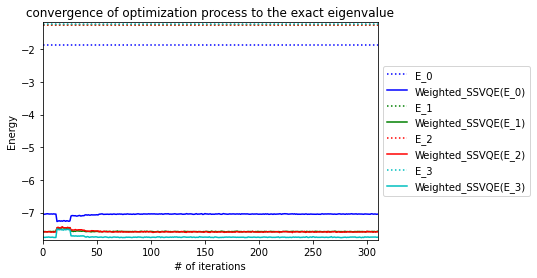

In [39]:
H2_approximated_energies = {'approximated_eneriges_0': [-7.044869071845908, -7.0522159431144695, -7.045826893427681, -7.040956622016025, -7.033636336738691, -7.03852022989153, -7.043777898111554, -7.0415561599539584, -7.04037809487655, -7.0453193426832215, -7.0373470588788996, -7.044564629495382, -7.044754815788807, -7.271419323963639, -7.26052383991807, -7.247357653224691, -7.261820010307763, -7.252539342679122, -7.2626464129237, -7.245920398831287, -7.247035733098027, -7.265952097434155, -7.24887083122739, -7.2531816673861735, -7.265940705468054, -7.25270662157792, -7.102617995399945, -7.089498116849218, -7.093325799353756, -7.096365339245411, -7.094106057615053, -7.107535385025435, -7.103305126646508, -7.091948777305775, -7.086315491445892, -7.10488835709718, -7.096982206618721, -7.0914861370367435, -7.093538444908571, -7.070529105326432, -7.067462257655455, -7.076956405751454, -7.066279474520601, -7.077988558064548, -7.076544412109634, -7.0658723955821845, -7.070992951297235, -7.071491621144808, -7.072676655189868, -7.069239264907494, -7.063587778613009, -7.072326880313549, -7.0486848773571, -7.046298838670843, -7.039678113562299, -7.039188863783721, -7.053704116853223, -7.052643297569627, -7.050661731110794, -7.049192506392741, -7.0476398150257715, -7.052762124552016, -7.048855537081967, -7.044614333935807, -7.05502435737143, -7.043489946891944, -7.042594008303074, -7.04959955388164, -7.052586159600431, -7.043061527383934, -7.046022024645883, -7.041379760574117, -7.046648212461671, -7.0441824707611245, -7.057042282144841, -7.046352543121911, -7.045337153671366, -7.049256240886576, -7.0378272540055065, -7.043903009848836, -7.048608550869771, -7.045266306647011, -7.050655640764568, -7.050509397550202, -7.041908116822447, -7.0526690959587155, -7.04823317227064, -7.041721783605734, -7.035312757770234, -7.042901180491823, -7.049113078824484, -7.044285463008793, -7.049442408039912, -7.0391089748590865, -7.041672722938562, -7.043665865505559, -7.043828664033352, -7.042920025064471, -7.0351881683253135, -7.043603402727344, -7.038009268423706, -7.039775544754238, -7.040883420582434, -7.037013595341853, -7.043819792934352, -7.042331437161471, -7.0456333038019405, -7.044548802876332, -7.038415766878813, -7.042968500357833, -7.03611416952854, -7.050432628509437, -7.043515351878789, -7.0364263386893064, -7.039288303056867, -7.0388500240705225, -7.03302407685042, -7.046960020729119, -7.044408693315892, -7.046657637715488, -7.04387014614952, -7.041187930508047, -7.034713210871416, -7.0424695121866945, -7.047725410183224, -7.04449085795552, -7.040806705875413, -7.0373853952318255, -7.037261842797666, -7.047859361581846, -7.049325843393123, -7.046151544622458, -7.043904221897233, -7.030302702310242, -7.0425612319577, -7.042291201514399, -7.038413698851512, -7.038412621015808, -7.043097019878359, -7.05238144474142, -7.051651858766015, -7.043762896318504, -7.031048444158597, -7.048869918982238, -7.044173709455461, -7.044276087098426, -7.039928716467672, -7.032741262414934, -7.05603933430837, -7.047712516719079, -7.029363034832074, -7.04120882235882, -7.038705395316446, -7.047649689091099, -7.043142711638445, -7.036958086099825, -7.050891397945634, -7.046994493016472, -7.04671562212142, -7.048569346180278, -7.039243574042099, -7.04302944528067, -7.040889111732697, -7.031685888156094, -7.044950083024378, -7.051877178085004, -7.046285775831468, -7.029559524717367, -7.037978211518291, -7.041085254242691, -7.044079649685425, -7.048988611826235, -7.0451941134830465, -7.037328268668186, -7.044100448273761, -7.040943041215821, -7.03914978891461, -7.0403395482554965, -7.046453268816699, -7.041288234787106, -7.039607543354191, -7.044551042858932, -7.038310324016002, -7.051193770196858, -7.036583203999625, -7.040478694265556, -7.038582313438599, -7.038909350623601, -7.042717248325647, -7.037321574213696, -7.0432663420012664, -7.049224888190789, -7.048931789809128, -7.043676795578305, -7.039809558091586, -7.045393069382596, -7.042396631840064, -7.043114992353083, -7.038462374140121, -7.046332291321339, -7.049023458842242, -7.044788845787949, -7.048339038543747, -7.046977441282405, -7.039777148935807, -7.049540827915558, -7.036962487132982, -7.045715536366187, -7.037443056104555, -7.051385449403388, -7.050145492134935, -7.042150341522066, -7.042889221955946, -7.053242066925324, -7.0390431325064755, -7.048359051553413, -7.045260503879417, -7.043482530079498, -7.042942267042148, -7.036513410863197, -7.0381343496658895, -7.052418453147576, -7.037468024799972, -7.038186713430111, -7.032175501130874, -7.0379334092469685, -7.036915083859438, -7.047553461406044, -7.045354491189099, -7.042785624301588, -7.039709867279104, -7.037032565711176, -7.045108922652119, -7.0357582699582135, -7.050000404547161, -7.0394185138961864, -7.052271352194985, -7.045606968052456, -7.0508600642674955, -7.0470800483045855, -7.043863452789584, -7.044813802868496, -7.050687813753245, -7.0407766824904545, -7.040842182847717, -7.052102298481224, -7.046337914315711, -7.04988918779328, -7.042104013380124, -7.0469319722733035, -7.047306057723097, -7.047469147761255, -7.046029336744473, -7.050346654126879, -7.043367589488681, -7.049975440549578, -7.048946922905914, -7.052610165294072, -7.038314824375851, -7.037340964972728, -7.046981363353354, -7.040413471602155, -7.041009311282204, -7.042602559535955, -7.037646386772052, -7.042514567980215, -7.038703779632361, -7.041529832962727, -7.042962754917504, -7.048786291588932, -7.043129547677769, -7.049021041423307, -7.049427252852342, -7.043836616413532, -7.036977436292433, -7.037620010721522, -7.047413988284011, -7.042065307986255, -7.039947338526112, -7.044411758976216, -7.051060299193217, -7.037766948566103, -7.047036104805181, -7.04021122655741, -7.044036139060423, -7.039718949602695, -7.033885499930792, -7.045033617714271, -7.041839583140589, -7.042374984054234, -7.03638371604375, -7.048445891340641, -7.041104828841519, -7.043251642420818, -7.043411931462254, -7.042924916028068, -7.046542176670868, -7.049764702707561, -7.040220654757975, -7.041801890197001, -7.045555266385649, -7.0430106557869046, -7.04329818292906, -7.049868368497418, -7.034838501816597, -7.038414717010243, -7.0480144131089215, -7.041535357301606, -7.043149083278204, -7.050721236368235, -7.04596017384676], 'approximated_eneriges_1': [-7.582453604466945, -7.582164266793541, -7.579073084596599, -7.585141242550659, -7.584589532241155, -7.5804643115002825, -7.5755634547601, -7.575600434478013, -7.582806656947542, -7.576958351501415, -7.574237985466983, -7.580187288314143, -7.574665472867071, -7.474764240900405, -7.4768714938741345, -7.466319706744727, -7.476154028838411, -7.471320885644612, -7.4590599683088294, -7.465030782155778, -7.475164569508971, -7.466084866348124, -7.477792033180828, -7.472963606706828, -7.4729137232137335, -7.466637719941649, -7.566267374472306, -7.557517351122575, -7.578861463899415, -7.566194514775459, -7.572894947849101, -7.558357851874592, -7.558189255072525, -7.562854661029755, -7.565416260195606, -7.56386180495245, -7.570649313607356, -7.559866728288295, -7.5649716056514675, -7.5763901452103095, -7.583014705078407, -7.576325392379665, -7.575686394573026, -7.57676889528636, -7.5855811909597595, -7.587406552562512, -7.576413156367478, -7.581672732639491, -7.582665201268557, -7.574126783110414, -7.5754863158538654, -7.575817174214625, -7.578319929886486, -7.583771883133503, -7.579308644768669, -7.581895500553291, -7.577818977719542, -7.579518614957346, -7.578770110736305, -7.568162483375374, -7.584272685036331, -7.575275136690887, -7.576691203553333, -7.583033572271182, -7.58628746773469, -7.571964290827396, -7.578726896842633, -7.576084156249764, -7.575686515562396, -7.560371684656434, -7.5816041152504186, -7.573564449240417, -7.575200458518374, -7.578389993722628, -7.58161482344728, -7.578346057217506, -7.578660232259293, -7.578358594053784, -7.576069944068362, -7.575499263179799, -7.575665722299441, -7.580105521608364, -7.583841927288854, -7.575701281027156, -7.5841062198935845, -7.5756327381698565, -7.576836709451854, -7.582683580777152, -7.583562878721634, -7.58548958816941, -7.575365428677632, -7.570096722992203, -7.5805140100552375, -7.583156825388065, -7.572553619199591, -7.580242430803599, -7.5690600027963955, -7.577282888503016, -7.584504157301762, -7.579320594284024, -7.574417626780096, -7.577251806051585, -7.581175922601044, -7.590788730721342, -7.58804567920823, -7.586773700746227, -7.574305306136674, -7.577466703824051, -7.59078398239154, -7.582840116308093, -7.5784948990982475, -7.576210269626564, -7.582801355603316, -7.567135133247455, -7.571236423881995, -7.583674639740933, -7.575546935778369, -7.5848395672040745, -7.578637870035943, -7.584649963135558, -7.583232044906465, -7.578037588333182, -7.575037024239425, -7.5756287278912575, -7.580846000257484, -7.575445583814912, -7.587356542975101, -7.585408529325551, -7.582830703653647, -7.579318293636298, -7.5817590405493, -7.569709966305507, -7.577143170455227, -7.58073497274696, -7.578116908199861, -7.58101963106108, -7.57939904963751, -7.580963758105738, -7.580014364562649, -7.576177639110013, -7.574832867592759, -7.57927102112272, -7.57933093475304, -7.586648373131018, -7.579089318160009, -7.5798338080276455, -7.580442009939318, -7.586558474218888, -7.582250053579411, -7.578917126849361, -7.583817756705378, -7.572648552241667, -7.576379678302254, -7.582520896345737, -7.58431330909813, -7.587561934482597, -7.566361872203952, -7.577275373294726, -7.584822521801764, -7.5808706572983615, -7.572063567264936, -7.587688658973814, -7.580834791459686, -7.582333173091506, -7.5823035713246245, -7.567910673030077, -7.570894732661367, -7.578778722501105, -7.579508916605638, -7.593317374148693, -7.585992876872101, -7.582597276594122, -7.576415967860754, -7.581530719038893, -7.585877906701415, -7.576638514263477, -7.583908549161456, -7.576221470782808, -7.57457610264675, -7.5691247473035, -7.567025061528623, -7.5799132440511965, -7.579811645932212, -7.576466217680586, -7.580157052176107, -7.591757723889211, -7.577075416560062, -7.581499536346734, -7.587283564693098, -7.579319569860482, -7.574807109706868, -7.5805662193633285, -7.577700088410532, -7.583070715978398, -7.572674908218506, -7.587958766585343, -7.585377991319518, -7.579335779957175, -7.583690752501266, -7.57262557018669, -7.58173539680413, -7.580513431597053, -7.578908209498602, -7.5795595447589585, -7.589571416086194, -7.57333933173756, -7.579656159422607, -7.576491857325173, -7.591484618841956, -7.5802494050358735, -7.58025279912429, -7.571051647913349, -7.581809926808362, -7.577714960144171, -7.581061186516403, -7.581860626666353, -7.582594915261997, -7.588702606385015, -7.5790945306775095, -7.582523368849969, -7.583575483069086, -7.588331770201276, -7.577268812603097, -7.574196242707301, -7.5824750573924184, -7.571801606472999, -7.573092497452785, -7.5798386558823925, -7.58364241206435, -7.5801244052688626, -7.57982770354082, -7.573945541936829, -7.575634335717406, -7.58218695853067, -7.5759007033048595, -7.577586904429252, -7.575193803613827, -7.584128590647623, -7.579224437618458, -7.573673400413032, -7.572686457314879, -7.5840459383690675, -7.589991900192306, -7.586290509143632, -7.573550999061493, -7.580272770111241, -7.584510686575842, -7.575049963974524, -7.582204805229044, -7.581051244278404, -7.577685458503512, -7.587445625374352, -7.570632450269072, -7.5751700775202595, -7.575880914264588, -7.58347947116411, -7.576308155287932, -7.577575435972919, -7.583437648836092, -7.584723768673469, -7.580372812491347, -7.579552059571315, -7.583758447271931, -7.580809011221502, -7.576743842393656, -7.579327348826819, -7.5831290999780805, -7.580064001665567, -7.576598908787449, -7.577558175438309, -7.570824510269273, -7.57063334016653, -7.585027271313368, -7.580571213051049, -7.582500776518187, -7.581365078016107, -7.581150660839033, -7.58085070568382, -7.586978004024601, -7.574014013013721, -7.57467488043918, -7.582420973797503, -7.580881153163834, -7.584832699162254, -7.5764164566720735, -7.577680274966804, -7.584624036983542, -7.588560624890894, -7.582218309682846, -7.577681480590064, -7.585395996797304, -7.576023030690075, -7.578464152585253, -7.576905118322982, -7.581184117379984, -7.580379077320153, -7.578419406429601, -7.583076596140048, -7.582102550404386, -7.587058322895608, -7.581828240210987, -7.576371745814872, -7.579504525545559, -7.582398541784724, -7.581065563326059, -7.575945081458147, -7.578834983689569, -7.575758190188583, -7.587162611711519, -7.580555918829417, -7.567371653372916], 'approximated_eneriges_2': [-7.578683503208721, -7.5931543389554745, -7.58787591756937, -7.586178677241158, -7.5937487883184485, -7.5812938657422615, -7.583926168551136, -7.595756167275311, -7.5974486898288465, -7.587645740415491, -7.601346607578855, -7.5891448369662315, -7.59006913160856, -7.45977719337515, -7.448862333994072, -7.461556900079808, -7.483217878018406, -7.447797282426053, -7.431932943974496, -7.464254381567711, -7.463471352482962, -7.462935813299841, -7.465931905634223, -7.448255452116852, -7.4747508958780005, -7.455763001010045, -7.530266269060302, -7.528081524502602, -7.5321690336747364, -7.530959017472535, -7.51697698886829, -7.531451174945902, -7.529980896053684, -7.524371709817597, -7.5239352110700235, -7.5212444905594245, -7.524311793017027, -7.541843004880607, -7.533990152827953, -7.553149049869688, -7.562279416050736, -7.5640291567026505, -7.568078403075637, -7.571108123884351, -7.564984270022434, -7.552673669647716, -7.552740280926134, -7.555693792106207, -7.56222478138485, -7.5632920781714, -7.561590573982431, -7.55926711734161, -7.588796822338731, -7.5636836007576775, -7.586232510201079, -7.592244313257442, -7.5759085914679405, -7.571123828980992, -7.580154201386861, -7.588135289239839, -7.582040543935425, -7.585254501805902, -7.576314599232319, -7.5842473182157, -7.595091525275136, -7.59866525513457, -7.591126887054619, -7.581667253914693, -7.587038521475237, -7.593265428179274, -7.587643994555676, -7.585605237479551, -7.5956134784723, -7.572780850163217, -7.596329586806689, -7.59031257249014, -7.587392576416836, -7.5947952581852025, -7.5898692552230065, -7.596194717517874, -7.59375647307333, -7.587755371898693, -7.587864540134338, -7.589406734705377, -7.5914119949821774, -7.581735489921218, -7.588877353827273, -7.587667133064402, -7.58608180760796, -7.5867041149041645, -7.594172569272973, -7.585666463638263, -7.5789639091580785, -7.592464114072826, -7.578293938676728, -7.592789806845936, -7.586469053338829, -7.579933734110607, -7.590437661459481, -7.576388785524825, -7.588923883612902, -7.59543439530978, -7.607208292759077, -7.596212683567193, -7.589175698091523, -7.587561697745929, -7.587917871413771, -7.590133249735344, -7.603500662010661, -7.597112041411421, -7.579564226040477, -7.587718617601744, -7.589768363462059, -7.59406574087067, -7.581628846576109, -7.579358057258006, -7.593281502502604, -7.5840229914972275, -7.597497416617267, -7.5891565613493075, -7.592391949007383, -7.586960987160365, -7.582701268727566, -7.591109524330426, -7.593871106184804, -7.58670081422275, -7.597273127181576, -7.590058394940967, -7.576949413568696, -7.588214086189539, -7.577575185627234, -7.599232900348659, -7.600687504491986, -7.603895690503902, -7.58082328397254, -7.5895617397182935, -7.592016390665446, -7.581246311448488, -7.601838570150319, -7.581161622114567, -7.581216963318931, -7.586389920002494, -7.589871001285056, -7.594352768386359, -7.585220361796463, -7.588173904448901, -7.588995293596656, -7.588775317687818, -7.593709008648448, -7.602806698640034, -7.583409983732506, -7.579684843283839, -7.591426815086892, -7.600291745124925, -7.603666030955258, -7.604348279535796, -7.5812941265869735, -7.589765095275158, -7.588901241629834, -7.5989647657620845, -7.589371082992922, -7.59817174245686, -7.594760943638512, -7.584335109560736, -7.595070496757898, -7.59255621022146, -7.586281303559234, -7.595198897831456, -7.604462273913371, -7.589747204514441, -7.599720754480531, -7.589208118030887, -7.597911856281437, -7.594335070639344, -7.585435798304614, -7.600101519266743, -7.593384079838442, -7.593542894893967, -7.5992396439312415, -7.580588914380738, -7.586902020337007, -7.589325398780175, -7.59817344395894, -7.588206524610579, -7.594955810207244, -7.585952655212365, -7.583922200309872, -7.585728743882994, -7.593416363241724, -7.5850186472792736, -7.591804838309055, -7.58679639181036, -7.594228564752007, -7.595780370208559, -7.574258156035539, -7.585311376675376, -7.589748275239228, -7.594772901771665, -7.593677884534406, -7.596885307264681, -7.596568390300541, -7.594878075782579, -7.590147057631574, -7.58815739361096, -7.602797301148743, -7.588978577195758, -7.592787955406494, -7.5852562284253375, -7.587439961046042, -7.585416220467494, -7.585276739270876, -7.5890684316371475, -7.596364168995866, -7.590150493524426, -7.592868916289156, -7.588865340238179, -7.5836404907562835, -7.581043414399546, -7.590079464120367, -7.609110826697228, -7.587982827673501, -7.592423607735933, -7.581291469574334, -7.584026486758773, -7.57728545151018, -7.583021098502603, -7.589345517380353, -7.590439157933853, -7.591102451174115, -7.591402339383597, -7.587035173432067, -7.611572478963275, -7.57941623869135, -7.59118431736744, -7.589927809405088, -7.58269713196266, -7.586870789539297, -7.588005384366656, -7.597552391881702, -7.587476992006394, -7.581438443852114, -7.589947609088305, -7.57161194005379, -7.6059050150464875, -7.5990277888459, -7.583939364459699, -7.593905802421668, -7.597398550635914, -7.589290039229096, -7.59069682900358, -7.5778804541942355, -7.599690770850041, -7.5925633837158895, -7.599086271877718, -7.592539981305608, -7.5848781566749075, -7.594628009166403, -7.587636908765328, -7.5895930673544845, -7.595182463143173, -7.592240683400318, -7.592459548310302, -7.5841028945577404, -7.604178358110788, -7.577115035409604, -7.5973285307493015, -7.593461167494049, -7.593093214833803, -7.583675165930156, -7.586809917779882, -7.5793886767747995, -7.594548129042497, -7.601607222365409, -7.589341216045241, -7.580152998244252, -7.6003639206009, -7.594343229812256, -7.600510000814319, -7.581945238754744, -7.599273560053577, -7.594283692343495, -7.597170155945373, -7.583584557739755, -7.584687065933869, -7.5936734801703745, -7.5908102511187145, -7.588671872447289, -7.5967225452812945, -7.595416109819035, -7.593707789947535, -7.591066175225888, -7.595479219847797, -7.5902173059568385, -7.5947883736292745, -7.590161788335861, -7.589153336047727, -7.594678068484873, -7.583352023206614, -7.592953578600243, -7.5982744954129915, -7.567993416796616, -7.5908272761439, -7.579081380529146, -7.589306556114438, -7.5789782758982, -7.596003051063719, -7.598161307392864, -7.584442740598526, -7.595376043673961, -7.582912994652124, -7.589969762679878], 'approximated_eneriges_3': [-7.751544766698706, -7.755382759898444, -7.7588573448875655, -7.750333908006543, -7.753121069313703, -7.745037975197169, -7.750176949528647, -7.755466555172707, -7.752643946802974, -7.749987250159876, -7.759991333025901, -7.759786517853326, -7.760442160539629, -7.49917168845674, -7.51460922469903, -7.5270629338962936, -7.513706349687308, -7.5250930626997645, -7.524332497938209, -7.534953033601943, -7.51170753447545, -7.525800797473628, -7.517337960712074, -7.510326877087334, -7.522635081351605, -7.517801924800858, -7.70927400304189, -7.713844043854497, -7.710928544333142, -7.717567954486238, -7.713134977641934, -7.714384431037695, -7.7204661880501275, -7.715471831346418, -7.719100079296667, -7.711764100315897, -7.715199721442915, -7.71042016364878, -7.7176306320087225, -7.7389091668549534, -7.749636419893328, -7.731983989302067, -7.739024891794881, -7.757064530690422, -7.746985739646444, -7.742441024609884, -7.740421591108306, -7.747960868678248, -7.744418583966718, -7.739187127889024, -7.744368994113976, -7.7555923855344195, -7.7520556582607165, -7.747695042019798, -7.746814141605138, -7.756591127615103, -7.756147240786697, -7.744265594630968, -7.7417374237762955, -7.74791986433853, -7.752843121990141, -7.763714012083222, -7.747956708887576, -7.756957077924681, -7.760430788177853, -7.747765866081701, -7.7457168829447705, -7.747901586545985, -7.753169826017695, -7.748831187685429, -7.753327633570565, -7.764772380347329, -7.756011705747082, -7.756288045410007, -7.765362534384527, -7.758175657817048, -7.7635629366169265, -7.749093032339201, -7.754377963311347, -7.751601196193235, -7.753033596042808, -7.754710234040921, -7.761871549000384, -7.758893311248456, -7.74914145849716, -7.753616758210788, -7.7496211916625795, -7.757549749652293, -7.743392334924374, -7.748935920008092, -7.747325754823692, -7.755444791584788, -7.75774245565876, -7.764217291584462, -7.746653194506497, -7.7526135879025935, -7.745004100387452, -7.754499107366891, -7.748881888378319, -7.7579724190158, -7.761344325183707, -7.752397411153568, -7.753203441245434, -7.751909085006676, -7.759162741062279, -7.752814014698454, -7.740462403281628, -7.743897452754459, -7.739636099047059, -7.762329416398708, -7.745074835586486, -7.754332579686614, -7.7600549377934165, -7.756234011997059, -7.747102805651635, -7.75106072860936, -7.755383699511321, -7.754220464582435, -7.747840629573525, -7.754768087642843, -7.746377899270535, -7.754572002739135, -7.741058540006747, -7.748729379962399, -7.741510109250558, -7.756909628533724, -7.7492764720880905, -7.756346424823958, -7.7601868286729445, -7.752304753870076, -7.7427309370649695, -7.742354828828864, -7.749159233434565, -7.753228158261914, -7.751241442177317, -7.752539413248214, -7.750372183896247, -7.741269790260364, -7.759455444029633, -7.750304915541718, -7.749108739830789, -7.760562480335842, -7.754459334360625, -7.755068815153284, -7.756727705656175, -7.732813342021415, -7.748564948269735, -7.74724238911974, -7.752181364316024, -7.7516508099875505, -7.747543675647448, -7.750707935823149, -7.7498325750013874, -7.755081079704518, -7.738907854230404, -7.758268291808157, -7.756613305849402, -7.7568890212229515, -7.764388841197386, -7.74525131541767, -7.745027950053753, -7.753513540377524, -7.757401531905581, -7.764042754455379, -7.756258663882559, -7.7602043361813005, -7.753631324493896, -7.7585219414541955, -7.751573689001982, -7.750242646751869, -7.74741078293913, -7.751597292941286, -7.747948266576574, -7.748005354695472, -7.754039515280349, -7.753227501341376, -7.7462033139824475, -7.752543874354947, -7.7500473238412395, -7.756912944723444, -7.751877842165016, -7.7550847184624025, -7.754764551897824, -7.7520208398071695, -7.7543749362775305, -7.755505430317207, -7.752310940237558, -7.76451842089832, -7.75862626465743, -7.76076798371711, -7.743357828286941, -7.7501897689298485, -7.753578341637515, -7.754677607223959, -7.755404625698354, -7.748690230742172, -7.7499106220184, -7.755472871803704, -7.756300948626108, -7.749333754505335, -7.7525381679054775, -7.7611435512498606, -7.755662749095439, -7.7548763759280614, -7.7471568175459335, -7.745585122667019, -7.750749461294535, -7.750242705368079, -7.760095966583469, -7.749853320777981, -7.748009302505093, -7.749961013747658, -7.757761654393711, -7.754986361398084, -7.755269561833093, -7.758009260023531, -7.751241906107987, -7.750981388751178, -7.7408813902344535, -7.764429830860316, -7.755096133188848, -7.752531558100684, -7.749141306010813, -7.752133983829143, -7.7487289579175584, -7.762405705225251, -7.754401557563736, -7.760284061940854, -7.756247080873755, -7.75245715987267, -7.761309652107444, -7.753339838029139, -7.745391634289997, -7.754594222253378, -7.748053189758376, -7.753557061623229, -7.750627092187286, -7.748122649964763, -7.762423575668679, -7.755679242461799, -7.7574460297856564, -7.747737220507729, -7.754730340807679, -7.752579196085017, -7.734891439904187, -7.75624097434428, -7.7621720359134345, -7.749293295970083, -7.744996151805008, -7.7571943399388985, -7.735088209550487, -7.744906121710207, -7.758347305074398, -7.746903433419974, -7.756164929621239, -7.756442032015691, -7.759331329514457, -7.755619997409755, -7.751213114134945, -7.7516168512232495, -7.755702331223667, -7.759133109597966, -7.751254906461934, -7.752815491153393, -7.761482448451672, -7.753233253022574, -7.75186228857032, -7.734068368624578, -7.759382558801796, -7.754597978505958, -7.746756505521222, -7.758638484432694, -7.756973637727583, -7.750423812727322, -7.754517387774341, -7.75989701896671, -7.766149017810932, -7.761312478121986, -7.75870589097194, -7.753175555115126, -7.750617134639217, -7.761143213227473, -7.754185958220965, -7.756809261611686, -7.750129819201203, -7.7465330904915275, -7.749467251878749, -7.745649796723613, -7.749341461425736, -7.743390135233459, -7.758878184914268, -7.757025641488555, -7.757425617534648, -7.747533690006613, -7.758228094783648, -7.7657387708064025, -7.75215188674995, -7.761769851335688, -7.741851715020775, -7.748987309803324, -7.7501568220416495, -7.74282055571017, -7.754881861741329, -7.749473645298008, -7.749204889272958, -7.752169577108456, -7.750895554677058, -7.7515134889857515, -7.746818115727269, -7.754709194507684, -7.751285718255909]}
plot_convergence_of_optimization_process(H2_approximated_energies, H2_molecule_Hamiltonian_4_qubits, margin=0.01)

##  Transverse Ising Model 4 qubits

In [40]:
transverse_ising_4_qubits = 0.0 * (I^I^I^I) \
    + 0.8398088405253477 * (X^I^I^I) \
    + 0.7989496312070936 * (I^X^I^I) \
    + 0.38189710487113193 * (Z^Z^I^I) \
    + 0.057753122422666725 * (I^I^X^I) \
    + 0.5633292636970458 * (Z^I^Z^I) \
    + 0.3152740621483513 * (I^Z^Z^I) \
    + 0.07209487981989715 * (I^I^I^X) \
    + 0.17892334004292654 * (Z^I^I^Z) \
    + 0.2273896497668042 * (I^Z^I^Z) \
    + 0.09762902934216211 * (I^I^Z^Z)

In [41]:
%%time
TI_approximated_k_eigenvalues = get_approximated_k_eigenvalues_of_hamiltonian(transverse_ising_4_qubits)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.46s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:15<00:00,  3.82s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.42s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.39s/it]


CPU times: total: 1h 3min 21s
Wall time: 1h 4min 46s


In [42]:
compare_exact_and_approximated_eigenvectors(transverse_ising_4_qubits, TI_approximated_k_eigenvalues)

Exact K Eigenvalues:
[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j)]

Approximated K Eigenvalues:
[1.4389654692879033, 2.5427714919716093, 1.9345385069457832, 1.4890864851176044]

Mean Approximation error:
0.20299633337569797


In [43]:
print(approximated_energies_dict)
approximated_energies_dict = initialize_approximated_energies_dict()

{'approximated_eneriges_0': [-7.627728607165679, -7.620037849299855, -7.615469272297405, -7.635882782725059, -7.6176727824645845, -7.625517365069324, -7.6366246794044, -7.6173377667525095, -7.6174970730502265, -7.613502020099884, -7.612866095747122, -7.615317321097156, -7.612205725658154, -7.627743210934677, -7.632359928563114, -7.615556491697861, -7.646671811154565, -7.627452049863276, -7.619773941240904, -7.638501814312888, -7.626880559431617, -7.6195948598226275, -7.630230148920304, -7.631895916476785, -7.61810441685143, -7.63658745812407, -7.645755816973782, -7.648387653982575, -7.646972106738409, -7.654097035351882, -7.649832969751938, -7.650693899454501, -7.653226328060971, -7.651644186974966, -7.648646298428571, -7.656131114665686, -7.639607550722119, -7.643617035163962, -7.654779923473547, -7.620582542906897, -7.636933028906796, -7.6375733831266555, -7.625951238215424, -7.636107076824787, -7.633870545062606, -7.632898620091147, -7.63057237409312, -7.646970118298904, -7.61916285

[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j)]


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


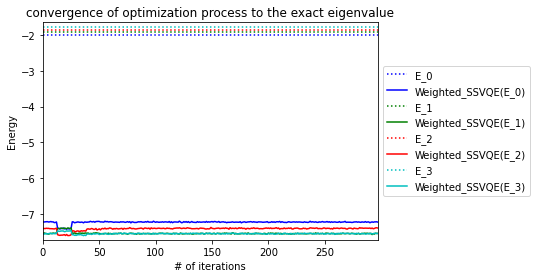

In [44]:
TI_approximated_energies = {'approximated_eneriges_0': [-7.230655824291587, -7.232156231813603, -7.2269118466834925, -7.224435292342758, -7.223090510850815, -7.232883464451508, -7.228534606397912, -7.219354944244936, -7.231064944404686, -7.228080867101087, -7.248782779735623, -7.245837078380108, -7.23217415595806, -7.406936545157612, -7.411831457927899, -7.430134402689202, -7.414265944626451, -7.416851880814031, -7.400408350428862, -7.427462455825711, -7.417112403651977, -7.434810143153512, -7.409863282248075, -7.427346672862717, -7.422754759252152, -7.404965523288016, -7.226943186680726, -7.230561909262265, -7.253943248477311, -7.246903128054697, -7.2376364884345, -7.230628484393112, -7.238475770984712, -7.243651868078656, -7.23567385988149, -7.240189611494555, -7.255884627062503, -7.231752576052941, -7.234520596353585, -7.239603528384539, -7.233885207667162, -7.232288789343925, -7.213622523440033, -7.225235252808737, -7.229912235896686, -7.218807050909878, -7.239032049689976, -7.220160787907363, -7.2163153136978035, -7.215508607064924, -7.217514511498871, -7.231954896099307, -7.2296714741882955, -7.232897976235796, -7.23671915877639, -7.210412586036357, -7.226610519232944, -7.217954881254602, -7.232063174593739, -7.227477410081558, -7.22418940679807, -7.227675986569633, -7.235965396635691, -7.24233631269727, -7.23379699546329, -7.234703612403967, -7.23508087823179, -7.2381244229018105, -7.242522157722863, -7.22545011836812, -7.234326155618267, -7.227091606180274, -7.236373035300872, -7.242479366897426, -7.235726190682856, -7.222299831383137, -7.23929324846661, -7.223227029274241, -7.256682736337177, -7.22755431910217, -7.234020343057368, -7.24547439399411, -7.245936366171937, -7.2448722042482165, -7.233421544314716, -7.226760703531076, -7.231403041353445, -7.223348320008962, -7.236209436597549, -7.237284228214967, -7.237086351618896, -7.2227428922274335, -7.236597662223316, -7.215213272528259, -7.2366175601210445, -7.236372515337477, -7.23378139932939, -7.239678024251709, -7.209977018523269, -7.228036674186689, -7.24120445822543, -7.227977743073735, -7.235555247511488, -7.241612289108028, -7.234355382241897, -7.237239537122246, -7.226822847088125, -7.238582037056109, -7.229715528846131, -7.229020963804856, -7.233930437028157, -7.238369981746838, -7.219061553625704, -7.248432422394126, -7.226410064889077, -7.251238789575872, -7.233621702768771, -7.230560965468209, -7.233126665159292, -7.236456409597164, -7.236985807434631, -7.209080550992588, -7.229348064880344, -7.253207894067526, -7.244851744551426, -7.222339372553338, -7.238784850816927, -7.22166865332316, -7.242762115068465, -7.222032233594889, -7.248488642944156, -7.238976567295522, -7.219009556806371, -7.238492619645845, -7.240190035190226, -7.241591759090362, -7.246143126531719, -7.223170840344449, -7.239156672984446, -7.230406176249597, -7.239779728598253, -7.236635133369277, -7.230763306589369, -7.229588430994365, -7.241729445862522, -7.217276949479711, -7.239918126486504, -7.226670667938001, -7.236228224012701, -7.226557442277676, -7.220181775697007, -7.234696495113567, -7.21866442584163, -7.221932457968856, -7.23350712090544, -7.2345189692494865, -7.217603129562463, -7.24551136255455, -7.2338363317123475, -7.229478026940409, -7.227224670906925, -7.238386476576431, -7.235947622214544, -7.2533286051484085, -7.239281164820781, -7.242676244778507, -7.2404320534315705, -7.237961914418423, -7.227765426077761, -7.238172338957211, -7.240418795584355, -7.23534521870218, -7.237472208938969, -7.23896936052762, -7.239446562558402, -7.224505532639014, -7.255045378639138, -7.2395972203564085, -7.231518858243917, -7.227586254785921, -7.243820387408635, -7.236821110961883, -7.229397814311788, -7.230458241979415, -7.2220092561007325, -7.227633519763264, -7.237948911093603, -7.223815065540219, -7.236247371937157, -7.233522867763223, -7.244506933607312, -7.228829589518504, -7.229575419310993, -7.229756751164102, -7.233194516496404, -7.240512133393528, -7.238160632291315, -7.23426508781678, -7.232962049991081, -7.2219132008464655, -7.248220236727849, -7.241637994352253, -7.2410873969477425, -7.223093799090048, -7.241487262172387, -7.227100985802835, -7.244157337271549, -7.228130258297405, -7.225592694637175, -7.230619033295259, -7.216665424362412, -7.243661109428171, -7.22352986332442, -7.236800906108402, -7.24431578174889, -7.2419659441983795, -7.249180739759378, -7.237421321661119, -7.224910782354195, -7.231841983484647, -7.241322974711623, -7.234127009283536, -7.2299625097876135, -7.230684222555189, -7.23700428772785, -7.229283613346334, -7.237321764578183, -7.230227672250537, -7.2335933695548205, -7.2365050778118984, -7.241236452552253, -7.243775317670092, -7.22639408357877, -7.23949849820077, -7.238180452840295, -7.24638119109773, -7.236256581617576, -7.212054729551554, -7.235289176899662, -7.226127665100424, -7.231602689899314, -7.23696558664305, -7.227442127044163, -7.240862399910503, -7.243898775733997, -7.227932376279429, -7.2368032897600285, -7.23054815019836, -7.220328072685952, -7.2340976972188615, -7.232601303264701, -7.2322988344501855, -7.219455639532654, -7.237211018125533, -7.224532746187833, -7.244491188531013, -7.226687934260373, -7.239541976434994, -7.233330306854079, -7.229050242331241, -7.237661542125556, -7.241127127604099, -7.237907000100805, -7.22187777336326, -7.244377641270739, -7.236358025550393, -7.233492165117918, -7.230423968851607, -7.214266446571548, -7.242337343771986, -7.237681710609208, -7.238001605199166, -7.235376459262585, -7.239170154605418, -7.2457223471380665, -7.241575636641166, -7.231149441259758, -7.23162829915286, -7.226566400063272, -7.2376870522820855, -7.23075129412491, -7.2372692965658745, -7.242438581084864, -7.229631853925922, -7.235736760163012, -7.238012607777581, -7.2207996997538615, -7.240512113021775, -7.231422839935761, -7.229856189296272, -7.2534681943734665, -7.238672033013341, -7.229692925943167, -7.240845083741161, -7.22922774464201, -7.229695535766312, -7.226610598619716, -7.235369410121787], 'approximated_eneriges_1': [-7.550683242962277, -7.538822863135065, -7.55008411662876, -7.55897796865705, -7.5632027489170826, -7.571948592178383, -7.560385446643115, -7.548556313213329, -7.557350382776294, -7.539623454091931, -7.554608404243045, -7.543805800289237, -7.552635230989461, -7.41748866035232, -7.4131605710874435, -7.414964422054285, -7.40205786354657, -7.408940043385269, -7.4192390558757255, -7.401615295588742, -7.411025352351437, -7.421010290318388, -7.401690746795952, -7.40417517482812, -7.4162558000248175, -7.397908971882198, -7.548923057644963, -7.546904128323561, -7.537370942920183, -7.560631342158139, -7.556976340568663, -7.560273628380784, -7.54430452309549, -7.543731717970082, -7.54818633166277, -7.543523800200846, -7.551414499272261, -7.5466198041360935, -7.539667932956796, -7.551645714623743, -7.538862222112098, -7.562295138781764, -7.55332466813669, -7.55641294673202, -7.556218619483761, -7.540866660026964, -7.545212656115853, -7.534946874032398, -7.542570699710828, -7.547096868400404, -7.553807940207289, -7.560199189958208, -7.561890029252995, -7.557121854128307, -7.554832078194802, -7.553704629848302, -7.555349916988187, -7.562804951811505, -7.544707827159325, -7.560204353132805, -7.55358193608607, -7.571005519951473, -7.557439496553331, -7.566095786379841, -7.55353072817666, -7.557675101533266, -7.5588578425861375, -7.546817344268718, -7.554652882560319, -7.542858506371966, -7.559609433119449, -7.5633202206735675, -7.551993438874603, -7.556593066198202, -7.556522200061691, -7.576482169720943, -7.558982153569666, -7.552108994671986, -7.544092461680996, -7.549386959976692, -7.55604436736714, -7.56663002661859, -7.557603825019027, -7.57597219383917, -7.549096241220243, -7.558338291953084, -7.569480878373801, -7.554975054877208, -7.56272165820795, -7.5538560975129, -7.556921992871783, -7.554024518465438, -7.557232533630467, -7.550615654836533, -7.564592721877621, -7.555498129722722, -7.569754026463483, -7.556325776674718, -7.561082045791271, -7.555653204839074, -7.553421577345177, -7.5638108159274156, -7.555597712756221, -7.549532088549326, -7.545794391815538, -7.54933930347947, -7.550947131685214, -7.557864130988, -7.559528132170389, -7.556113894153712, -7.54713899610519, -7.552075673500586, -7.5548836593173325, -7.562954938356408, -7.568867207428206, -7.554963719680873, -7.548680943666945, -7.552222876645382, -7.551841268146282, -7.556709155786664, -7.566096760519089, -7.569017170131674, -7.541787800400642, -7.556953061587577, -7.568509133649472, -7.56095440417102, -7.563144288945327, -7.549792402098119, -7.559501275831297, -7.5549071287459535, -7.5642991678225675, -7.551434529493169, -7.568404711014954, -7.573174050281887, -7.561251223246477, -7.555577276726262, -7.5639830990618515, -7.553438975257628, -7.553223301196071, -7.559058502220418, -7.546610118938945, -7.554150547318012, -7.5547881052282335, -7.57394668447194, -7.55581333138479, -7.544552569726852, -7.559495717543246, -7.5512159438824344, -7.556732611377398, -7.561626393637131, -7.566125278460293, -7.550860731860758, -7.547120653510534, -7.567891500009217, -7.559897056877579, -7.547229439818355, -7.554616445258716, -7.549905267646238, -7.562823620108678, -7.551832377008666, -7.556215151401625, -7.541832704185849, -7.549834009326433, -7.543759004986976, -7.556177775140475, -7.553130123896612, -7.558764599205452, -7.568678416059024, -7.536316271504655, -7.539566808598727, -7.569794118614989, -7.54826552268222, -7.563213559398289, -7.563586590532436, -7.563357946972766, -7.56449243196982, -7.551549493511942, -7.556788457208167, -7.554605845898709, -7.549301604957866, -7.549256299203932, -7.563124916479237, -7.537711191305687, -7.56084446024711, -7.559250234185563, -7.566763171451585, -7.556389915734708, -7.556562449101039, -7.5674707805078, -7.541754662855211, -7.559762193303108, -7.548460464886603, -7.554569664380687, -7.56085713240549, -7.561329665646655, -7.565231063614005, -7.552214902866351, -7.55021715047876, -7.57456741735939, -7.564551633420716, -7.543170762950222, -7.562290966614618, -7.540049075028705, -7.553530119011748, -7.544002501820431, -7.5672867103945345, -7.548030815033093, -7.548045691457346, -7.552495419599777, -7.555201363568631, -7.569751786599874, -7.548389452280374, -7.569318545520066, -7.5583551029780836, -7.564391720035807, -7.553567267215852, -7.560895124738541, -7.557424696478318, -7.567694847030491, -7.5565367220982385, -7.574118234369145, -7.561551078356445, -7.55449413546597, -7.569749979638946, -7.5489113666304, -7.556567860078667, -7.553595588280471, -7.55526180797587, -7.560393154569164, -7.5593118613025565, -7.55036790399995, -7.557962327701532, -7.562275794925345, -7.562525712648386, -7.564246148807295, -7.5551786896418625, -7.5571712986381865, -7.55258224270072, -7.553230158291084, -7.565559563874206, -7.550426796905481, -7.562155126547323, -7.537269898300711, -7.561162641385397, -7.5483183741395035, -7.5631623346616275, -7.556378903045296, -7.556801181997425, -7.550058619891834, -7.5640480149969, -7.558658917279983, -7.543861551851747, -7.547173974115072, -7.550577681045478, -7.561716440678923, -7.558409814338887, -7.552705674552182, -7.550037948010117, -7.549165761317303, -7.571757583835817, -7.564694526104574, -7.555666889939895, -7.562154738573207, -7.563277126344072, -7.56526660154923, -7.5625647680912715, -7.542881660555917, -7.554257598760987, -7.561379045441735, -7.556062561109061, -7.550863430729272, -7.550834104439993, -7.564164431198491, -7.557775005234187, -7.546211102075424, -7.554257203233912, -7.556254880533049, -7.559289364937038, -7.570457983152539, -7.5580062705260564, -7.54863397125863, -7.570783936678156, -7.56409808967914, -7.548862960439668, -7.561953452200041, -7.546232642716481, -7.551103331043392, -7.550179395728152, -7.547915363708788, -7.559735929973729, -7.548090965991739, -7.5557390949559196, -7.584170566175145, -7.557306216303866, -7.571676501223552, -7.54772621208632, -7.551036900911758, -7.552493737346103], 'approximated_eneriges_2': [-7.410444364672608, -7.415714453423059, -7.415938097126615, -7.408017966663016, -7.411926696725731, -7.410701573897746, -7.419352878341387, -7.419158949271299, -7.420415015254557, -7.424619761587982, -7.4268511180459065, -7.418024427836759, -7.404609945520007, -7.589386998779999, -7.600319421387095, -7.607455138580125, -7.599492255637303, -7.6015256592593765, -7.595930672716543, -7.58717224388028, -7.60987806854404, -7.582168037686289, -7.612525084715747, -7.611666484836461, -7.60652734066912, -7.587143701774609, -7.4837958290812105, -7.479734294459937, -7.491546169546624, -7.5111811400213115, -7.486656111152134, -7.482032814626383, -7.494604961911633, -7.494052164683773, -7.478067560055237, -7.486570495236522, -7.479730591071314, -7.4797851754636735, -7.486953928064199, -7.433142530036842, -7.4229755855042985, -7.432500450937396, -7.43294364150897, -7.414775693820271, -7.422289122079512, -7.439332189153368, -7.438893758915969, -7.413233120318137, -7.456667893399677, -7.441987027768607, -7.425008769691984, -7.454469381106106, -7.421554336127311, -7.413712774429379, -7.425844973393581, -7.402824712762297, -7.428095926295256, -7.416441753264347, -7.420259300551505, -7.399259445603592, -7.403695766936157, -7.416449591510461, -7.435755442790675, -7.414893307446768, -7.427560288995593, -7.412783417340669, -7.420330177171769, -7.427486797178415, -7.423377363706668, -7.416514061956097, -7.409451610631072, -7.438749449046901, -7.408960013709229, -7.421516106416111, -7.420611253255005, -7.413942378961346, -7.413595982264582, -7.390780588843896, -7.4084622853888735, -7.42124209464471, -7.412880469775962, -7.420777016827756, -7.427536960587946, -7.425587323265961, -7.418111470884228, -7.4143275263345165, -7.410316651774604, -7.401856447363387, -7.411822767959461, -7.431389462225188, -7.403089235376795, -7.401598556814728, -7.411348628632633, -7.414386324492143, -7.402957302521619, -7.432926701674536, -7.396649841473121, -7.415251855041303, -7.411428762397702, -7.406042320381719, -7.4145398335250325, -7.4152709291939685, -7.40658424014324, -7.405066053058349, -7.411548528475879, -7.414008371571924, -7.4123205752620835, -7.406722186984054, -7.417842283938753, -7.419830930402007, -7.400463799038998, -7.412282021683004, -7.40771656019699, -7.4192285057796425, -7.420192856399023, -7.428356692686373, -7.4114023837419865, -7.406367352937335, -7.40361213017597, -7.399731151408673, -7.403760125167092, -7.39514265976909, -7.4066343168997175, -7.416274937994275, -7.410738319182156, -7.402652742009214, -7.412648898988432, -7.411130390161757, -7.393913775543006, -7.401729989208781, -7.408164367202596, -7.410458637641345, -7.420930170929184, -7.420162114969175, -7.4193824884112995, -7.41955380606936, -7.41431645729939, -7.414111034016485, -7.427604797401894, -7.4100578315655685, -7.401925274129811, -7.408904048852081, -7.40917138906226, -7.414023819414739, -7.427551921566607, -7.428652238971265, -7.421105014760246, -7.426059034712438, -7.421227742998169, -7.384943157249668, -7.409354186033169, -7.41566556688613, -7.4214593382824505, -7.415144527375948, -7.408267821484224, -7.406554894795174, -7.402385639726274, -7.419116895868815, -7.409447232301686, -7.410747900640483, -7.403283885417719, -7.414859601277965, -7.3958330821863445, -7.4102185671681875, -7.409901753007446, -7.4349614409928675, -7.3914259123102255, -7.416534441131431, -7.408995196211471, -7.410313765251155, -7.415287726486965, -7.39998041723367, -7.4202562928892455, -7.413155506758194, -7.392766031853719, -7.410718186662607, -7.3941527335440105, -7.4140329976786, -7.410883145425181, -7.411236343181268, -7.433653854220001, -7.4124161445611065, -7.410523350736927, -7.423066054748081, -7.417395045470075, -7.405232589932642, -7.411695349205476, -7.393438544782937, -7.413070092312006, -7.411845736178486, -7.405986199902686, -7.412877320568309, -7.423637869512572, -7.417485122778937, -7.420346375249428, -7.421874620879591, -7.412471538840202, -7.408661648174666, -7.398806523365515, -7.409703274160633, -7.401502370816964, -7.415019489819521, -7.397996366552989, -7.416879606328125, -7.409568524824878, -7.412450181316362, -7.4043174398596, -7.390707254328941, -7.4144954187659415, -7.4008468406208126, -7.432212658353873, -7.417689790331265, -7.416297950401478, -7.420371265411078, -7.399711767696046, -7.418632969604109, -7.411531656365526, -7.41259101043679, -7.400612471388634, -7.4129388286238695, -7.397720546438961, -7.429951027389409, -7.428525938671341, -7.408518580725819, -7.407733315774913, -7.403006436670952, -7.403562707208992, -7.4180326153299525, -7.424593788196596, -7.42401998096983, -7.421705156615664, -7.404396708972521, -7.415199440338291, -7.411222660695321, -7.429646219900774, -7.418526018129546, -7.415979223492038, -7.3950969048259605, -7.400558588908429, -7.405183376463522, -7.404814221232868, -7.4108782549620065, -7.404578883465207, -7.397070653288616, -7.419287643385738, -7.415031097689276, -7.415169554445011, -7.420820684775902, -7.4149458976195355, -7.398974222998238, -7.4018094514863755, -7.4190927912145845, -7.40660299251048, -7.410718862777842, -7.408100477638087, -7.4251843746433055, -7.414906996945376, -7.431118038850682, -7.400281442721625, -7.4126205211633005, -7.40787768217344, -7.403092498243889, -7.409253836038857, -7.417143768118361, -7.4061200321664975, -7.400927261585105, -7.412065658573083, -7.410234665650475, -7.408906590251693, -7.426580069577404, -7.431152043071313, -7.409979137262973, -7.405085762880571, -7.405375805653347, -7.415085497284975, -7.428865699646528, -7.401761293027105, -7.412241800401161, -7.414960843288435, -7.421647163637885, -7.4154040320456165, -7.391043169754898, -7.405554611504087, -7.398829731574355, -7.408414720800373, -7.406586104670398, -7.404128438382962, -7.406072069560908, -7.40628852023641, -7.407877820661062, -7.402004918163509, -7.416688848785448, -7.402282440897539, -7.421522438989727, -7.41322314959422, -7.3976270021053905, -7.393738169656054, -7.401149522147831], 'approximated_eneriges_3': [-7.565665224802693, -7.571558557541593, -7.563488411786494, -7.5535972819342545, -7.568265658658191, -7.55764361817917, -7.549862490270664, -7.552378085418476, -7.561530453734309, -7.557885510897533, -7.550194896715531, -7.561191639341913, -7.547381220635373, -7.478847184356431, -7.493074318994978, -7.4936530929344505, -7.484656587329637, -7.4850404374973944, -7.48397222059697, -7.502882932513469, -7.497784126206931, -7.48061204741115, -7.488002033465607, -7.485254643745074, -7.482741338968084, -7.476596274780958, -7.58745351778472, -7.589352564985627, -7.604498448591276, -7.603986963079971, -7.60551920715375, -7.579345775953151, -7.594499215719384, -7.577776377931761, -7.594834362967512, -7.598861258957919, -7.614058213583621, -7.599076254034332, -7.610889082645888, -7.570468971532068, -7.565978169378039, -7.5689900582031, -7.56371558736955, -7.581395302038702, -7.569812845506195, -7.558061138578111, -7.57025094955635, -7.561662791049137, -7.559440699252352, -7.5591156104895205, -7.584113721903352, -7.569875517183606, -7.558351982919966, -7.561801548837393, -7.574467881363289, -7.549593226392686, -7.552273850283872, -7.569034967857946, -7.578802333381693, -7.566025496212142, -7.5587455859661565, -7.576459631268144, -7.561951100321032, -7.547104104469302, -7.564615613182923, -7.549965663541954, -7.5645195346878, -7.558149543969611, -7.554149140026431, -7.54245441822292, -7.5663544547300665, -7.555466278495125, -7.542851281074657, -7.552867299265858, -7.557246120884814, -7.562512200772655, -7.557729570157427, -7.548701524163326, -7.556629212603531, -7.562703070038278, -7.550158579897595, -7.557899460876809, -7.572583496985447, -7.556899857227568, -7.558109722433135, -7.543851154833375, -7.5510141824102615, -7.5736155602900626, -7.563360428348574, -7.547099219791205, -7.562822948215396, -7.566482515865028, -7.558787451469362, -7.556713812874585, -7.548583757587774, -7.562869475049058, -7.57078625456337, -7.566871254827781, -7.545176860647729, -7.571038541090749, -7.558378445475016, -7.558554328273203, -7.5640839014068035, -7.553778686511179, -7.558744848456306, -7.556879426146582, -7.539270801287508, -7.559349035216264, -7.556619401877544, -7.55933301867962, -7.558763567968391, -7.560433931647151, -7.563306035220907, -7.555059625283163, -7.556514978356334, -7.5671196377135885, -7.548457871207328, -7.574302889855866, -7.548241349502122, -7.556506780978408, -7.562947648240894, -7.557627833978751, -7.558031548956967, -7.553053133979084, -7.551161697722563, -7.557668696358851, -7.553807041628483, -7.557504336344521, -7.563768060767367, -7.559352004099949, -7.556503680915647, -7.54624800608743, -7.5678519641943085, -7.5426564498654525, -7.552297667857417, -7.559257779584226, -7.542668377833022, -7.557672004746245, -7.563448690659477, -7.559049301944132, -7.569165597455367, -7.544354950612827, -7.5499565930042705, -7.569860040564563, -7.5641490323006195, -7.550623222632321, -7.550514992597756, -7.558251804357427, -7.539828941350091, -7.55566232225068, -7.559678722135635, -7.560015820058426, -7.556801562259494, -7.566537275261356, -7.553064531028829, -7.548098479251611, -7.559985898201188, -7.565321530733754, -7.570869680141159, -7.554814630220452, -7.560505089273475, -7.565614656322719, -7.569028398909243, -7.547996809309446, -7.5664089455734, -7.550368842223157, -7.559795486797088, -7.541665676127119, -7.550089253965164, -7.5458670317836045, -7.553665967844049, -7.563936972176008, -7.560662269817603, -7.568667883986726, -7.5593734629693445, -7.5470354738758765, -7.561173656994816, -7.5424587924253155, -7.566303314591444, -7.562030367717736, -7.5560945532955275, -7.5766387156603585, -7.55790879145774, -7.558002418794064, -7.561704822479739, -7.5572186777597326, -7.565383783550966, -7.564248092630112, -7.542284617055556, -7.562128937563885, -7.547824673351669, -7.561777556251198, -7.5610090539379655, -7.552147351853727, -7.560794348824769, -7.563898039889992, -7.557013161047448, -7.573540345041206, -7.566905869413926, -7.57600834063447, -7.552371347093251, -7.555707984710987, -7.5644290606653115, -7.561914204862563, -7.559597381947844, -7.566880361745033, -7.57536927030609, -7.57056387243906, -7.565040990817158, -7.544954460939858, -7.5551845038135195, -7.56399852895941, -7.577609511622952, -7.559229812886538, -7.545124565157558, -7.550217690463665, -7.563742098340991, -7.561404415432949, -7.568860579358517, -7.570400075958647, -7.549757454804531, -7.572396927050729, -7.566226342594929, -7.553919302071998, -7.559697974169244, -7.566223465086674, -7.5390758326632525, -7.568494161923016, -7.550127108590029, -7.552933589818219, -7.563651853617645, -7.561104417454871, -7.541477275422324, -7.557756030360809, -7.55533249204703, -7.558900869064141, -7.555633514385122, -7.545413150167204, -7.554998988840136, -7.554953103488577, -7.56904469782563, -7.5571134000403655, -7.567999492576593, -7.560807573425701, -7.543779000768876, -7.565146911478062, -7.552412295678639, -7.562826424402587, -7.549464531576674, -7.568419161862177, -7.559471585349289, -7.573540563551335, -7.557952950896124, -7.555608147763329, -7.557356430298694, -7.567542313132486, -7.542182882707864, -7.565994613995024, -7.558524876948161, -7.578865973010801, -7.552717730416121, -7.572777962204683, -7.549903472783061, -7.557174238191128, -7.544273588204877, -7.55075254170614, -7.548722288848476, -7.5560627662135245, -7.554451536490434, -7.551615126174713, -7.55063467207524, -7.556887920783522, -7.554619773436095, -7.559158327825837, -7.5544038736168995, -7.557438674400187, -7.559357089605574, -7.572227309132768, -7.548021619199864, -7.561561151050764, -7.552085181079079, -7.564528582858334, -7.563319348025164, -7.56118837594011, -7.553830965704677, -7.55987891905092, -7.571607103462974, -7.568215034765017, -7.559707868972947, -7.555750141435884, -7.565404624717864, -7.550693539944269, -7.565729179048917, -7.563673079856357, -7.548448932343774, -7.548227144408689, -7.55813043032206, -7.552842495614734]}
plot_convergence_of_optimization_process(TI_approximated_energies, transverse_ising_4_qubits, )